<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-all-sessions" data-toc-modified-id="Load-all-sessions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load all sessions</a></span><ul class="toc-item"><li><span><a href="#JG14190621" data-toc-modified-id="JG14190621-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>JG14190621</a></span></li><li><span><a href="#JG14_190619" data-toc-modified-id="JG14_190619-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>JG14_190619</a></span></li><li><span><a href="#JG14_190626" data-toc-modified-id="JG14_190626-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>JG14_190626</a></span></li><li><span><a href="#JG15_190722" data-toc-modified-id="JG15_190722-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>JG15_190722</a></span></li><li><span><a href="#JG15_190725" data-toc-modified-id="JG15_190725-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>JG15_190725</a></span></li><li><span><a href="#JG18a_190814" data-toc-modified-id="JG18a_190814-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>JG18a_190814</a></span></li><li><span><a href="#JG18b_190828" data-toc-modified-id="JG18b_190828-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>JG18b_190828</a></span></li></ul></li><li><span><a href="#Behaviour-Analysis" data-toc-modified-id="Behaviour-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Behaviour Analysis</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#generate-tables" data-toc-modified-id="generate-tables-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>generate tables</a></span></li><li><span><a href="#creating-plots" data-toc-modified-id="creating-plots-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>creating plots</a></span></li></ul></li><li><span><a href="#SDA" data-toc-modified-id="SDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SDA</a></span><ul class="toc-item"><li><span><a href="#Bootstrapping" data-toc-modified-id="Bootstrapping-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Bootstrapping</a></span><ul class="toc-item"><li><span><a href="#WRONG-get-spikes-for-random-windows-for-all-clusters-all-trials" data-toc-modified-id="WRONG-get-spikes-for-random-windows-for-all-clusters-all-trials-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>WRONG get spikes for random windows for all clusters all trials</a></span></li><li><span><a href="#NEW-Bootstrap" data-toc-modified-id="NEW-Bootstrap-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>NEW Bootstrap</a></span></li><li><span><a href="#Analyze" data-toc-modified-id="Analyze-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Analyze</a></span></li></ul></li></ul></li><li><span><a href="#Workbench" data-toc-modified-id="Workbench-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Workbench</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scipy.stats as st
import importlib
import os
import sys
import platform
import qgrid
import datetime
from scipy.interpolate import make_interp_spline, BSpline
import pickle
import random

from numba import njit

from sync_class import SyncPhenosys
from eda_class import SpikesEDA
from behavior_class import BehaviorAnalysis
from sda_class import SpikesSDA
from report_class import SpikesReport


%load_ext autoreload
%autoreload 2

#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)

%matplotlib notebook
#plt.style.use('ggplot')
#plt.style.use('gadfly.mplstyle')

# %config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

# dark theme



# ============================================================================================================================
# specify file path & sessions

windows_folder = r"C:/Users/User/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
linux_folder = "/home/max/ExpanDrive/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
mac_folder = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"

# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[]),
         ]



# ============================================================================================================================
# Load sessions functions

def add_session(session, gamble_side, sync_obj, missing_rows_ttl, combined, trials, behavior, spikes, trials_skip):
    session_dict = {
        'session':session,
        'gamble_side':gamble_side,
        #'sync_obj':sync_obj,
        'missing_rows_ttl':missing_rows_ttl,
        'combined':combined,
        'trials':trials,
        'behavior':behavior,
        'trials_skip':trials_skip,
    }
    if spikes != False:
        session_dict['spikes']=spikes
        
    # add session dict to all sessions dict
    all_sessions_dict[session]=session_dict
    return session_dict


def load_session(session, missing_rows_ttl=[], lo_spikes=False, trials_skip=[]):

    # load calss and set folder depending on platform

    # load calss and set folder depending on platform
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder + '/' + session
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder + r"/" + session
    elif platform.system() == 'Darwin':
        folder = mac_folder + r"/" + session

    sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl)   
    gamble_side = sync_obj.gamble_side

    # first find missing rows
    #missing_rows_csv = []
    #combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)
    #trials_df = sync_obj.get_trials(combined)
    behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
    
    if lo_spikes:
        spikes_obj = SpikeAnalysis(behavior_obj)
    #    spikes = SpikeAnalysis(session, folder, sync_obj)
    #    for a,b in trials_skip:
    #        if b == 'end':
    #            spikes.trials_df.loc[a:,'select'] = False
    #        else:
    #            spikes.trials_df.loc[a:b,'select'] = False
    #else:
    #    spikes = False

    return session, gamble_side, sync_obj, behavior_obj, spikes_obj


def load_all_sessions(se_li):
    all_sessions = dict()
    for session, missing_rows_ttl, lo_spikes, trials_skip in se_li:
        session, gamble_side, sync_obj, combined, trials, behavior, spikes = load_session(session, missing_rows_ttl, lo_spikes, trials_skip)
        
        session_dict = add_session(session, gamble_side, sync_obj, missing_rows_ttl, combined, trials, behavior, spikes, trials_skip)  
        all_sessions[session]=session_dict

    return all_sessions


        
# ============================================================================================================================
# save & load sessions from pickl functions

# save dict to pickl
def save_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    with open(file, 'wb') as dump:
        pickle.dump(all_sessions_dict, dump)

# load dict from pickl
def load_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    
    with open(file, 'rb') as dump:
        all_sessions_dict = pickle.load(dump)
    return all_sessions_dict

In [16]:
#@njit(fastmath=True)
# binn data
def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        for it in range(iterations):
            data_ar[cl,:,it]=(np.histogram(np.concatenate(input_ar[cl,:,it]).ravel(),bins=nr_bins))[0]
    return data_ar



---

In [32]:
%%time

session = 'JG14_190621'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl = [1900,1931,1996,2058,2127]
# behavior
deselect_trials = [(0,6),(215,'end')]
# sda
window = 2000
iterations = 1000
bins = 50

sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
eda_obj = SpikesEDA(behavior_obj)
sda_obj = SpikesSDA(eda_obj)
sda_obj.spiketimes_data_ar, sda_obj.reward_aligned_ar, sda_obj.binned, sda_obj.mean_ar, sda_obj.percentil_ar = sda_obj.get_bootstrap_all_clusters(window, iterations,bins,'reward')
report_obj = SpikesReport(eda_obj)

JG14_190621 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })


[autoreload of sda_class failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/ma

AttributeError: module 'numba' has no attribute 'core'

In [ ]:
%%time

#JG14_190621.eda.generate_plots()
#JG14_190621.sda.generate_plots()
#JG14_190621.report.generate_report()

In [33]:
%%time

session = 'JG18b_190828'
folder = mac_folder + r"/" + session
# sync
rows_missing_ttl = [1744, 2363, 2648, 2701, 2731, 2778,2953,2967]
# behavior
deselect_trials = [(0,0),(204,'end')]
# eda
skip_clusters = [116, 280]
# sda
window = 2000
iterations = 1000
bins = 50

sync_obj = SyncPhenosys(session, folder, 7, 1, rows_missing_ttl) 
behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
eda_obj = SpikesEDA(behavior_obj)
sda_obj = SpikesSDA(eda_obj)
sda_obj.spiketimes_data_ar, sda_obj.reward_aligned_ar, sda_obj.binned, sda_obj.mean_ar, sda_obj.percentil_ar = sda_obj.get_bootstrap_all_clusters(window, iterations,bins,'reward')
report_obj = SpikesReport(eda_obj)

JG18b_190828 = type('obj', (object,), 
                   {'sync':sync_obj,
                    'behavior':behavior_obj,
                    'eda':eda_obj,
                    'sda': sda_obj,
                    'report': report_obj,
                   })



[autoreload of sda_class failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/ma

AttributeError: module 'numba' has no attribute 'core'

In [ ]:
%%time

#JG18b_190828.eda.generate_plots()
#JG18b_190828.sda.generate_plots()
#JG18b_190828.report.generate_report()

# Load all sessions

## JG14190621

In [7]:
session = 'JG14_190621'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [9]:

sync_obj = SyncPhenosys(session, folder, 7, 1)    


# first find missing rows
missing_rows_ttl = [1900,1931,1996,2058,2127]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [10]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [11]:
sync_obj.ttl_info_channel

Start  Length                Event
1       184261      17                start
3       204966      39                  cue
5       205627      61                sound
7       206346      80             openloop
9       346501     178  no response in time
...        ...     ...                  ...
4333  22450560     216                  end
4335  22450817      21                start
4337  22470860      37                  cue
4339  22471517      61                sound
4341  22472202      76             openloop

[2171 rows x 3 columns]

<IPython.core.display.Javascript object>


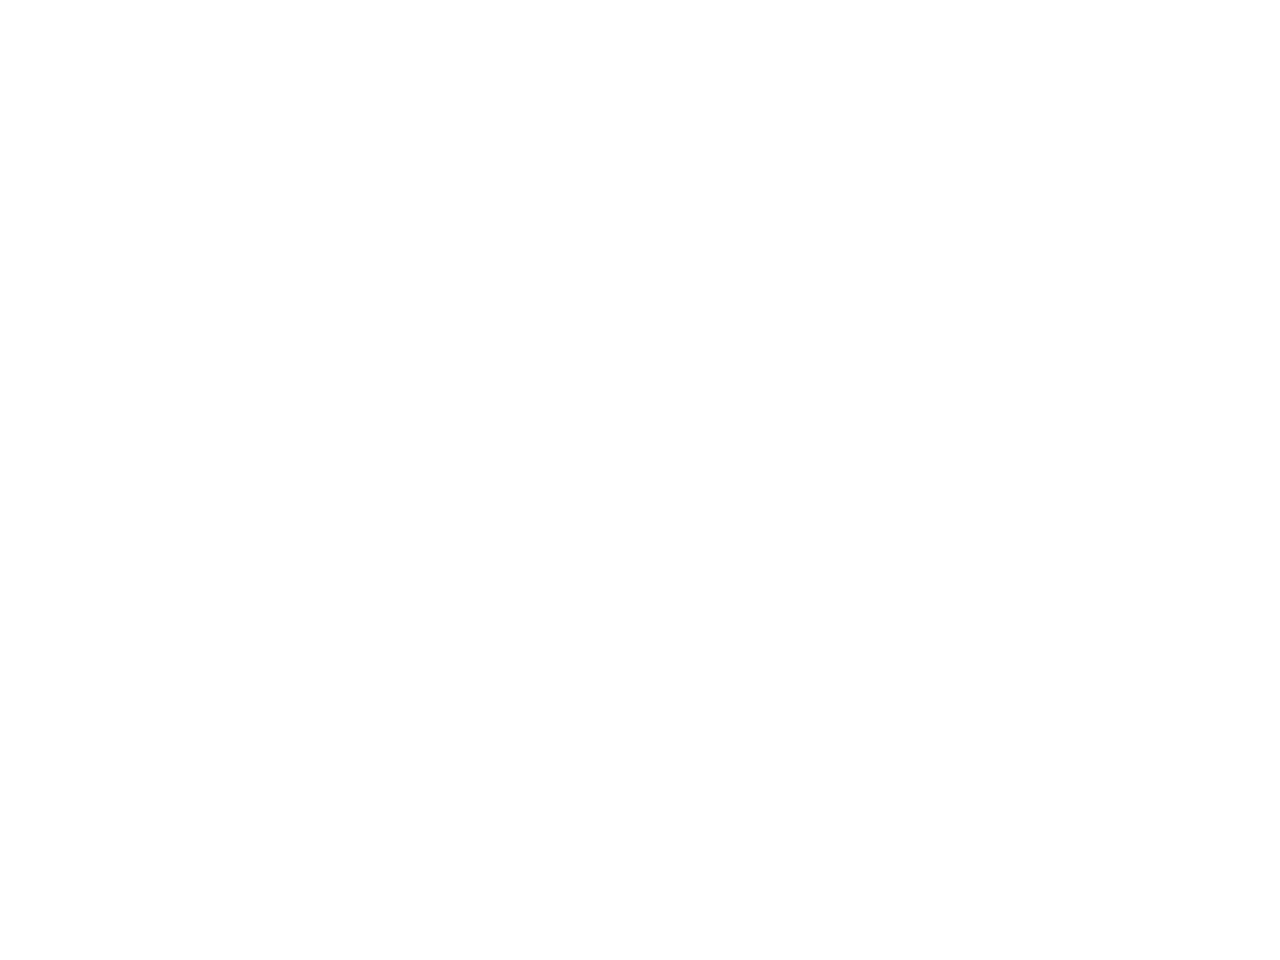

In [12]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [13]:
 behavior = BehaviorAnalysis(session, folder, combined)


<IPython.core.display.Javascript object>


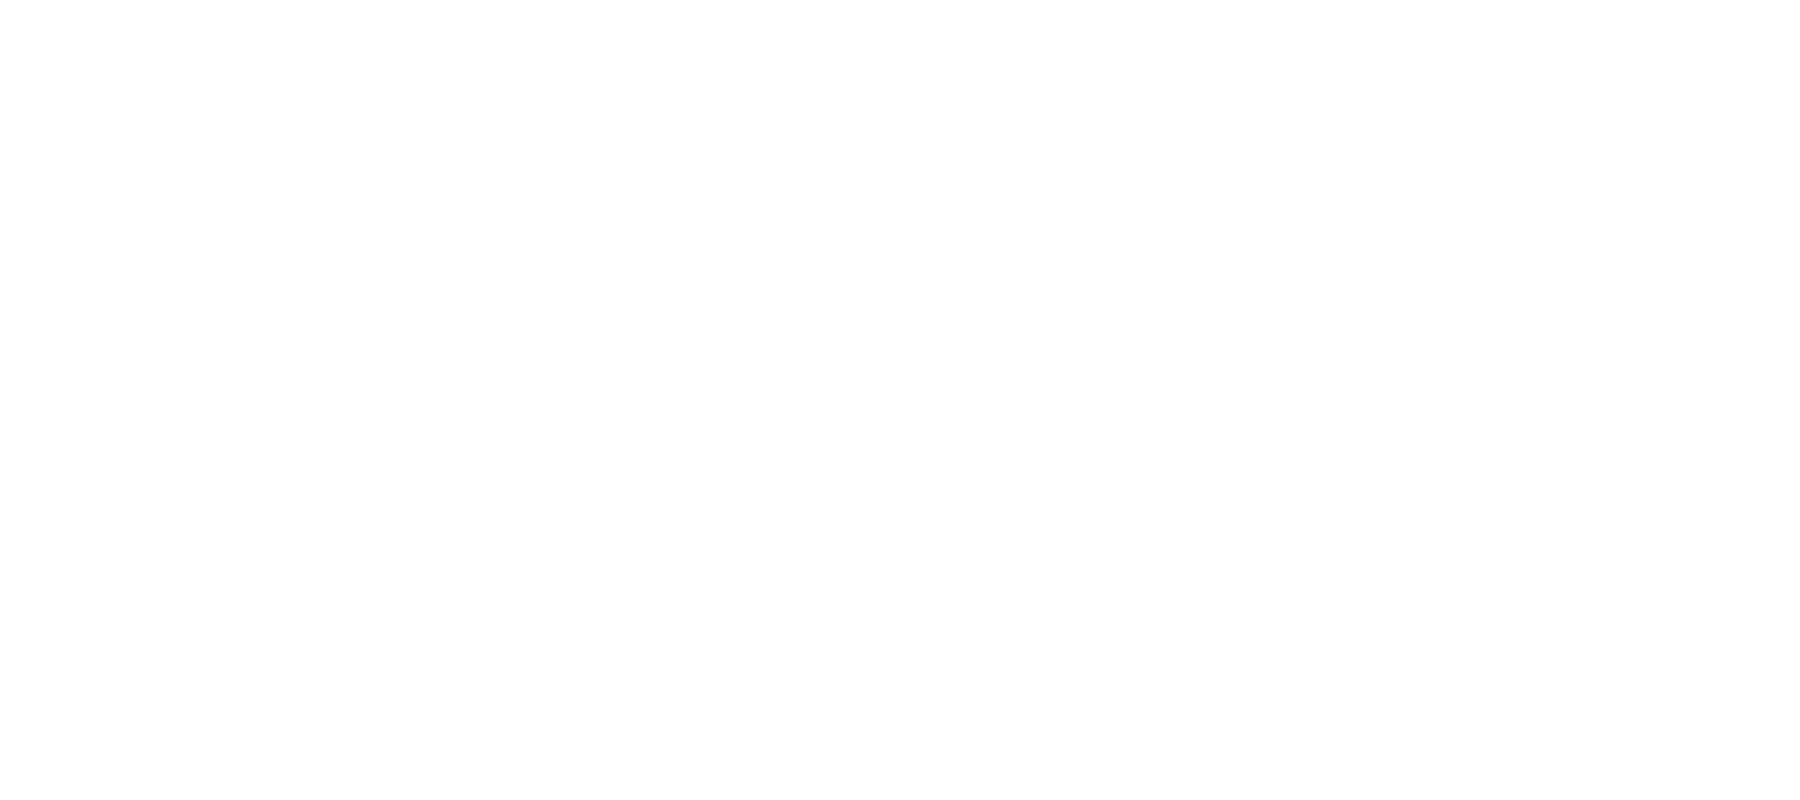

In [14]:
behavior.plot_wheel_resp()


---

In [15]:
spikes = SpikeAnalysis(session, folder, gambl_side)
spikes.trials_df.loc[0:6, 'select'] = False
spikes.trials_df.loc[215:, 'select'] = False
qgrid.show_grid(spikes.trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [16]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, spikes)

## JG14_190619

In [17]:
session = 'JG14_190619'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [18]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [111, 2781]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [19]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [20]:
sync_obj.ttl_info_channel

Start  Length     Event
1       359352      21     start
3       379614      40       cue
5       380253     218       end
7       381155      98  right_rw
9       483200     140   left_rw
...        ...     ...       ...
5631  26486281     218       end
5633  26486539      21     start
5635  26506600      40       cue
5637  26507240      60     sound
5639  26507920      80  openloop

[2820 rows x 3 columns]

<IPython.core.display.Javascript object>


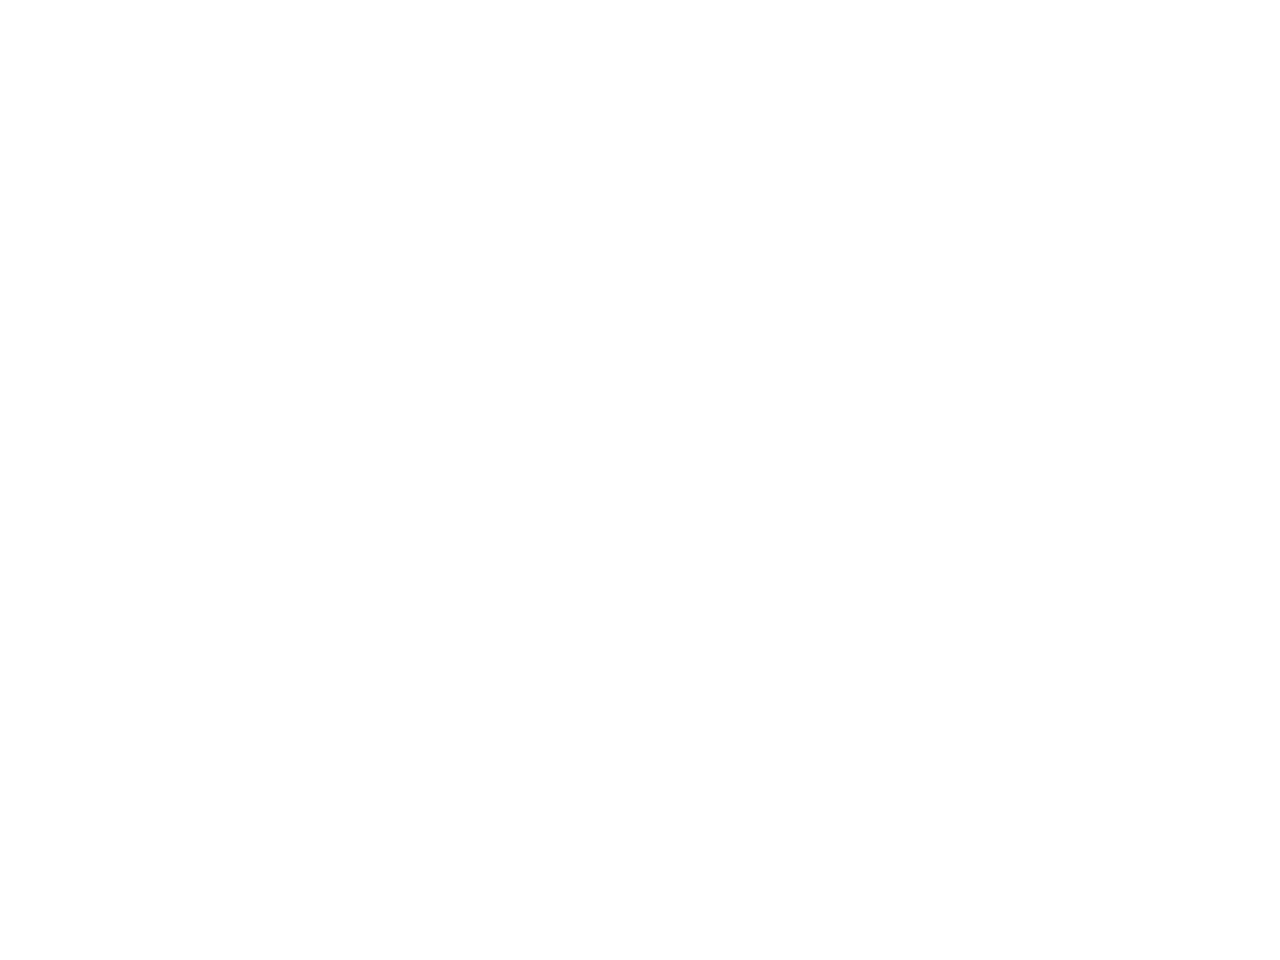

In [21]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [22]:
 behaviour = BehaviorAnalysis(session, folder, combined)


<IPython.core.display.Javascript object>


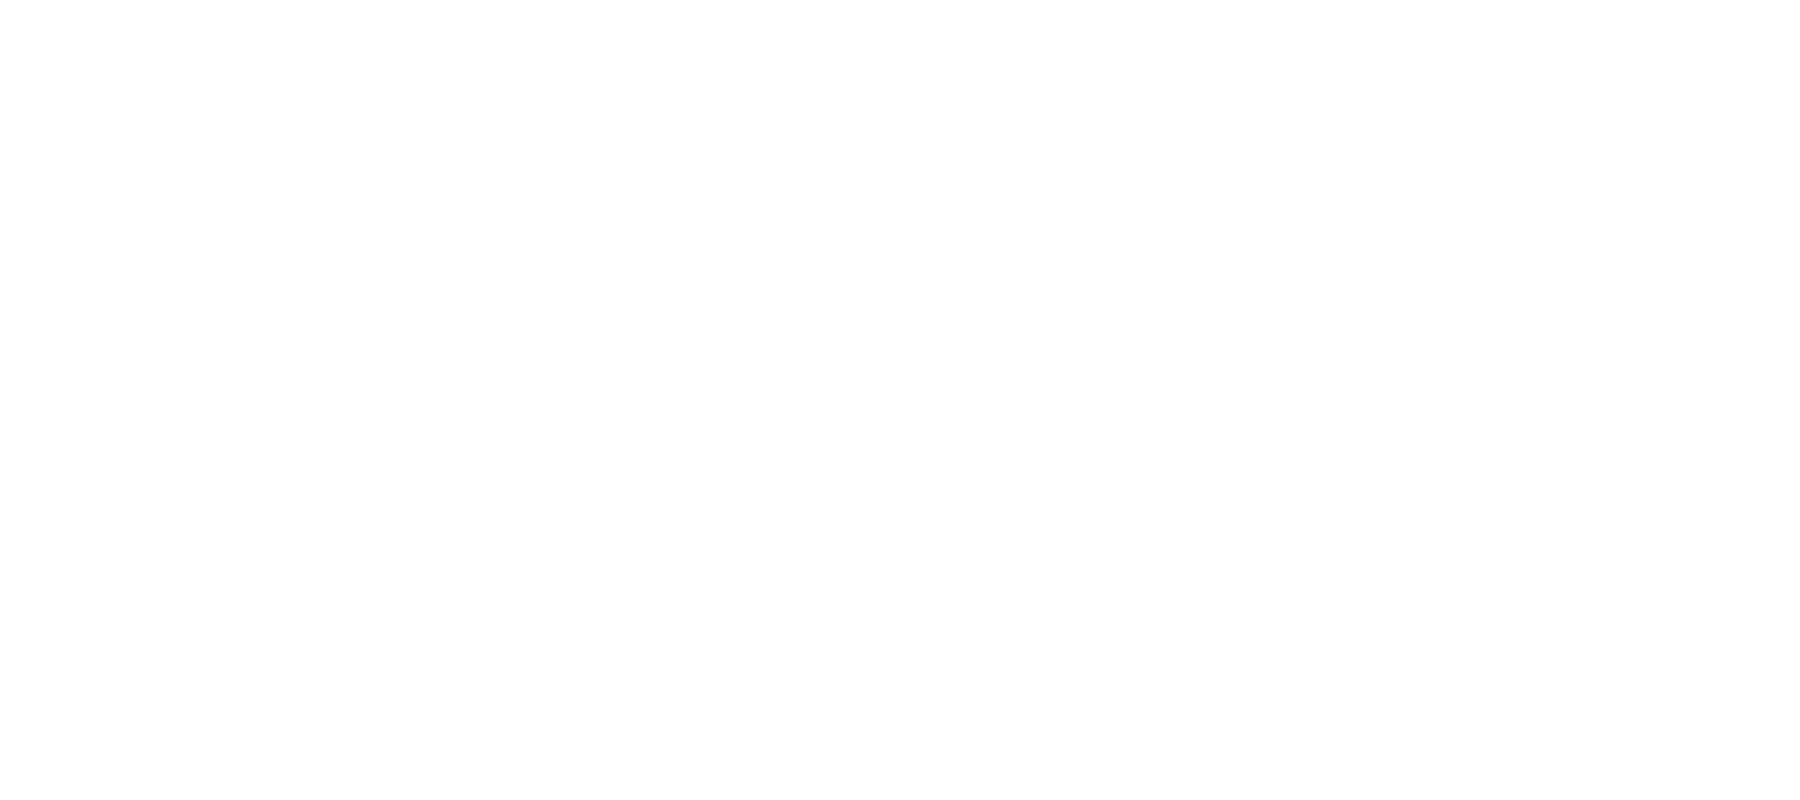

In [23]:
behaviour.plot_wheel_resp()

In [24]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [25]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG14_190626

In [26]:
session = 'JG14_190626'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG15_190722

In [ ]:
session = 'JG15_190722'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [2094, 2574, 2637, 2808, 2831, 3499]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG15_190725

In [ ]:
session = 'JG15_190725'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG18a_190814

In [ ]:
session = 'JG18a_190814'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [405,2621,2693,2770,2959,3015,3029,3038,3048]  #401
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side

qgrid.show_grid(combined)

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
#spikes = SpikeAnalysis(session, folder, gambl_side)
#spikes.trials_df.loc[0:6, 'select'] = False
#spikes.trials_df.loc[215:, 'select'] = False
#qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, None)

## JG18b_190828

In [ ]:
session = 'JG18b_190828'

# load calss and set folder depending on platform
if platform.system() == 'Linux':
    # Linux
    folder = linux_folder + '/' + session
elif platform.system() == 'Windows':
    # windows
    folder = windows_folder + r"/" + session
elif platform.system() == 'Darwin':
    folder = mac_folder + r"/" + session

In [ ]:
sync_obj = SyncPhenosys(session, folder, 7, 1)  
missing_rows_ttl = [1744, 2363, 2648, 2701, 2731, 2778,2953,2967]
missing_rows_csv = []
combined = sync_obj.combine_dataframes(missing_rows_ttl, missing_rows_csv, 'channel 1', sync_obj.csv, False)

gambl_side = sync_obj.gambl_side


qgrid.show_grid(combined)

In [ ]:
gambl_side

In [ ]:
trials = sync_obj.get_trials(combined)
qgrid.show_grid(trials)

In [ ]:
sync_obj.ttl_info_channel

In [ ]:
plt.figure()
combined['Delta (TTL-CSV)'].plot()
plt.show()

---

In [ ]:
 behaviour = BehaviorAnalysis(session, folder, combined)


In [ ]:
behaviour.plot_wheel_resp()

In [ ]:
spikes = SpikeAnalysis(session, folder, gambl_side)
spikes.trials_df.loc[0:6, 'select'] = False
spikes.trials_df.loc[215:, 'select'] = False
qgrid.show_grid(spikes.trials_df)

In [ ]:
add_session(session, gambl_side, sync_obj, missing_rows_ttl, trials, behavior, spikes)

# Behaviour Analysis

In [2]:


def convert_numeric(columns, df):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    return df

def get_trial_info(all_sessions_dict):
    session_info_df = pd.DataFrame(columns=['Session','Gambl Side','prop bins', 
                                       'Trials', 'tot. Trials','wheel ns','no resp',
                                       'right chosen', 'right rewarded',
                                       'left chosen', 'left rewarded',
                                      ])
    
    for key in all_sessions_dict.keys():
        session_dict = all_sessions_dict[key]
        session=session_dict['session']
        gambl_side=session_dict['gambl_side']
        #sync_obj=session_dict['sync_obj']
        missing_rows_ttl=session_dict['missing_rows_ttl']
        missing_rows_ttl = missing_rows_ttl[0]
        combined=session_dict['combined']
        #combined = combined[0]
        trials=session_dict['trials']
        #trials=trials[0]
        behavior=session_dict['behavior']
        #behavior=behavior[0]
        #spikes=session_dict['spikes']
        
        prop_bin=list((combined['CSV Probability']).dropna().unique())
        # get info form combined
        all_trials = int(combined.index.get_level_values(0).max())
        good_trials = int(combined.index.get_level_values(1).max())
        wheel_ns = all_trials - good_trials
        
        no_resp = (combined['CSV Event']=='no response in time').sum(axis=0)
        right_ch = (combined['CSV Event']=='right_norw').sum(axis=0) + (combined['CSV Event']=='right_rw').sum(axis=0)
        right_rw = (combined['CSV Event']=='right_rw').sum(axis=0)
        left_ch = (combined['CSV Event']=='left_norw').sum(axis=0) + (combined['CSV Event']=='left_rw').sum(axis=0)
        left_rw = (combined['CSV Event']=='left_rw').sum(axis=0)
        
        session_info_df.loc[session_info_df.shape[0] + 1] = [session,gambl_side,prop_bin,
                                                             good_trials,all_trials,wheel_ns,no_resp,
                                                             right_ch,right_rw,
                                                             left_ch,left_rw]
        
        session_info_df = convert_numeric(['Trials', 'tot. Trials','wheel ns','no resp','right chosen', 
                         'right rewarded','left chosen', 'left rewarded'],
                       session_info_df)
        
    return session_info_df

In [3]:
def boxplot(df,columns,scatter=True,title=None):
    plt.figure()
    session_info_df.boxplot(column=columns,return_type='axes')
    
    if scatter:
        i = 1
        for column in columns:
            y=session_info_df[column] 
            x=np.ones(y.shape[0])*i
            plt.plot(x, y, 'r.', alpha=0.5)
            i+=1

    plt.ylabel('Trial')
    plt.title(title)

    plt.show()

In [66]:
#all_sessions_dict = load_all_sessions_dict_pickl()

session_info_df = get_trial_info(all_sessions_dict)
session_info_df

Session Gambl Side            prop bins  Trials  tot. Trials  \
1   JG14_190621      right  [0.75, 0.25, 0.125]     266          569   
2   JG14_190619      right  [0.125, 0.25, 0.75]     278         1143   
3   JG14_190626      right  [0.125, 0.25, 0.75]     358         1297   
4   JG15_190722       left  [0.125, 0.25, 0.75]     438          936   
5   JG15_190725      right  [0.75, 0.25, 0.125]     472          899   
6  JG18a_190814       left  [0.125, 0.25, 0.75]     399          649   
7  JG18b_190828      right  [0.75, 0.25, 0.125]     374          726   

   wheel ns  no resp  right chosen  right rewarded  left chosen  left rewarded  
1       303       26           101              42          140            126  
2       865        9            94              57          176            159  
3       939       43           111              63          205            185  
4       498       58           248             223          133             82  
5       427       76           139              64          258            232  
6       250       29           188             169          183            114  
7       352       33           109              43          233            209

<IPython.core.display.Javascript object>


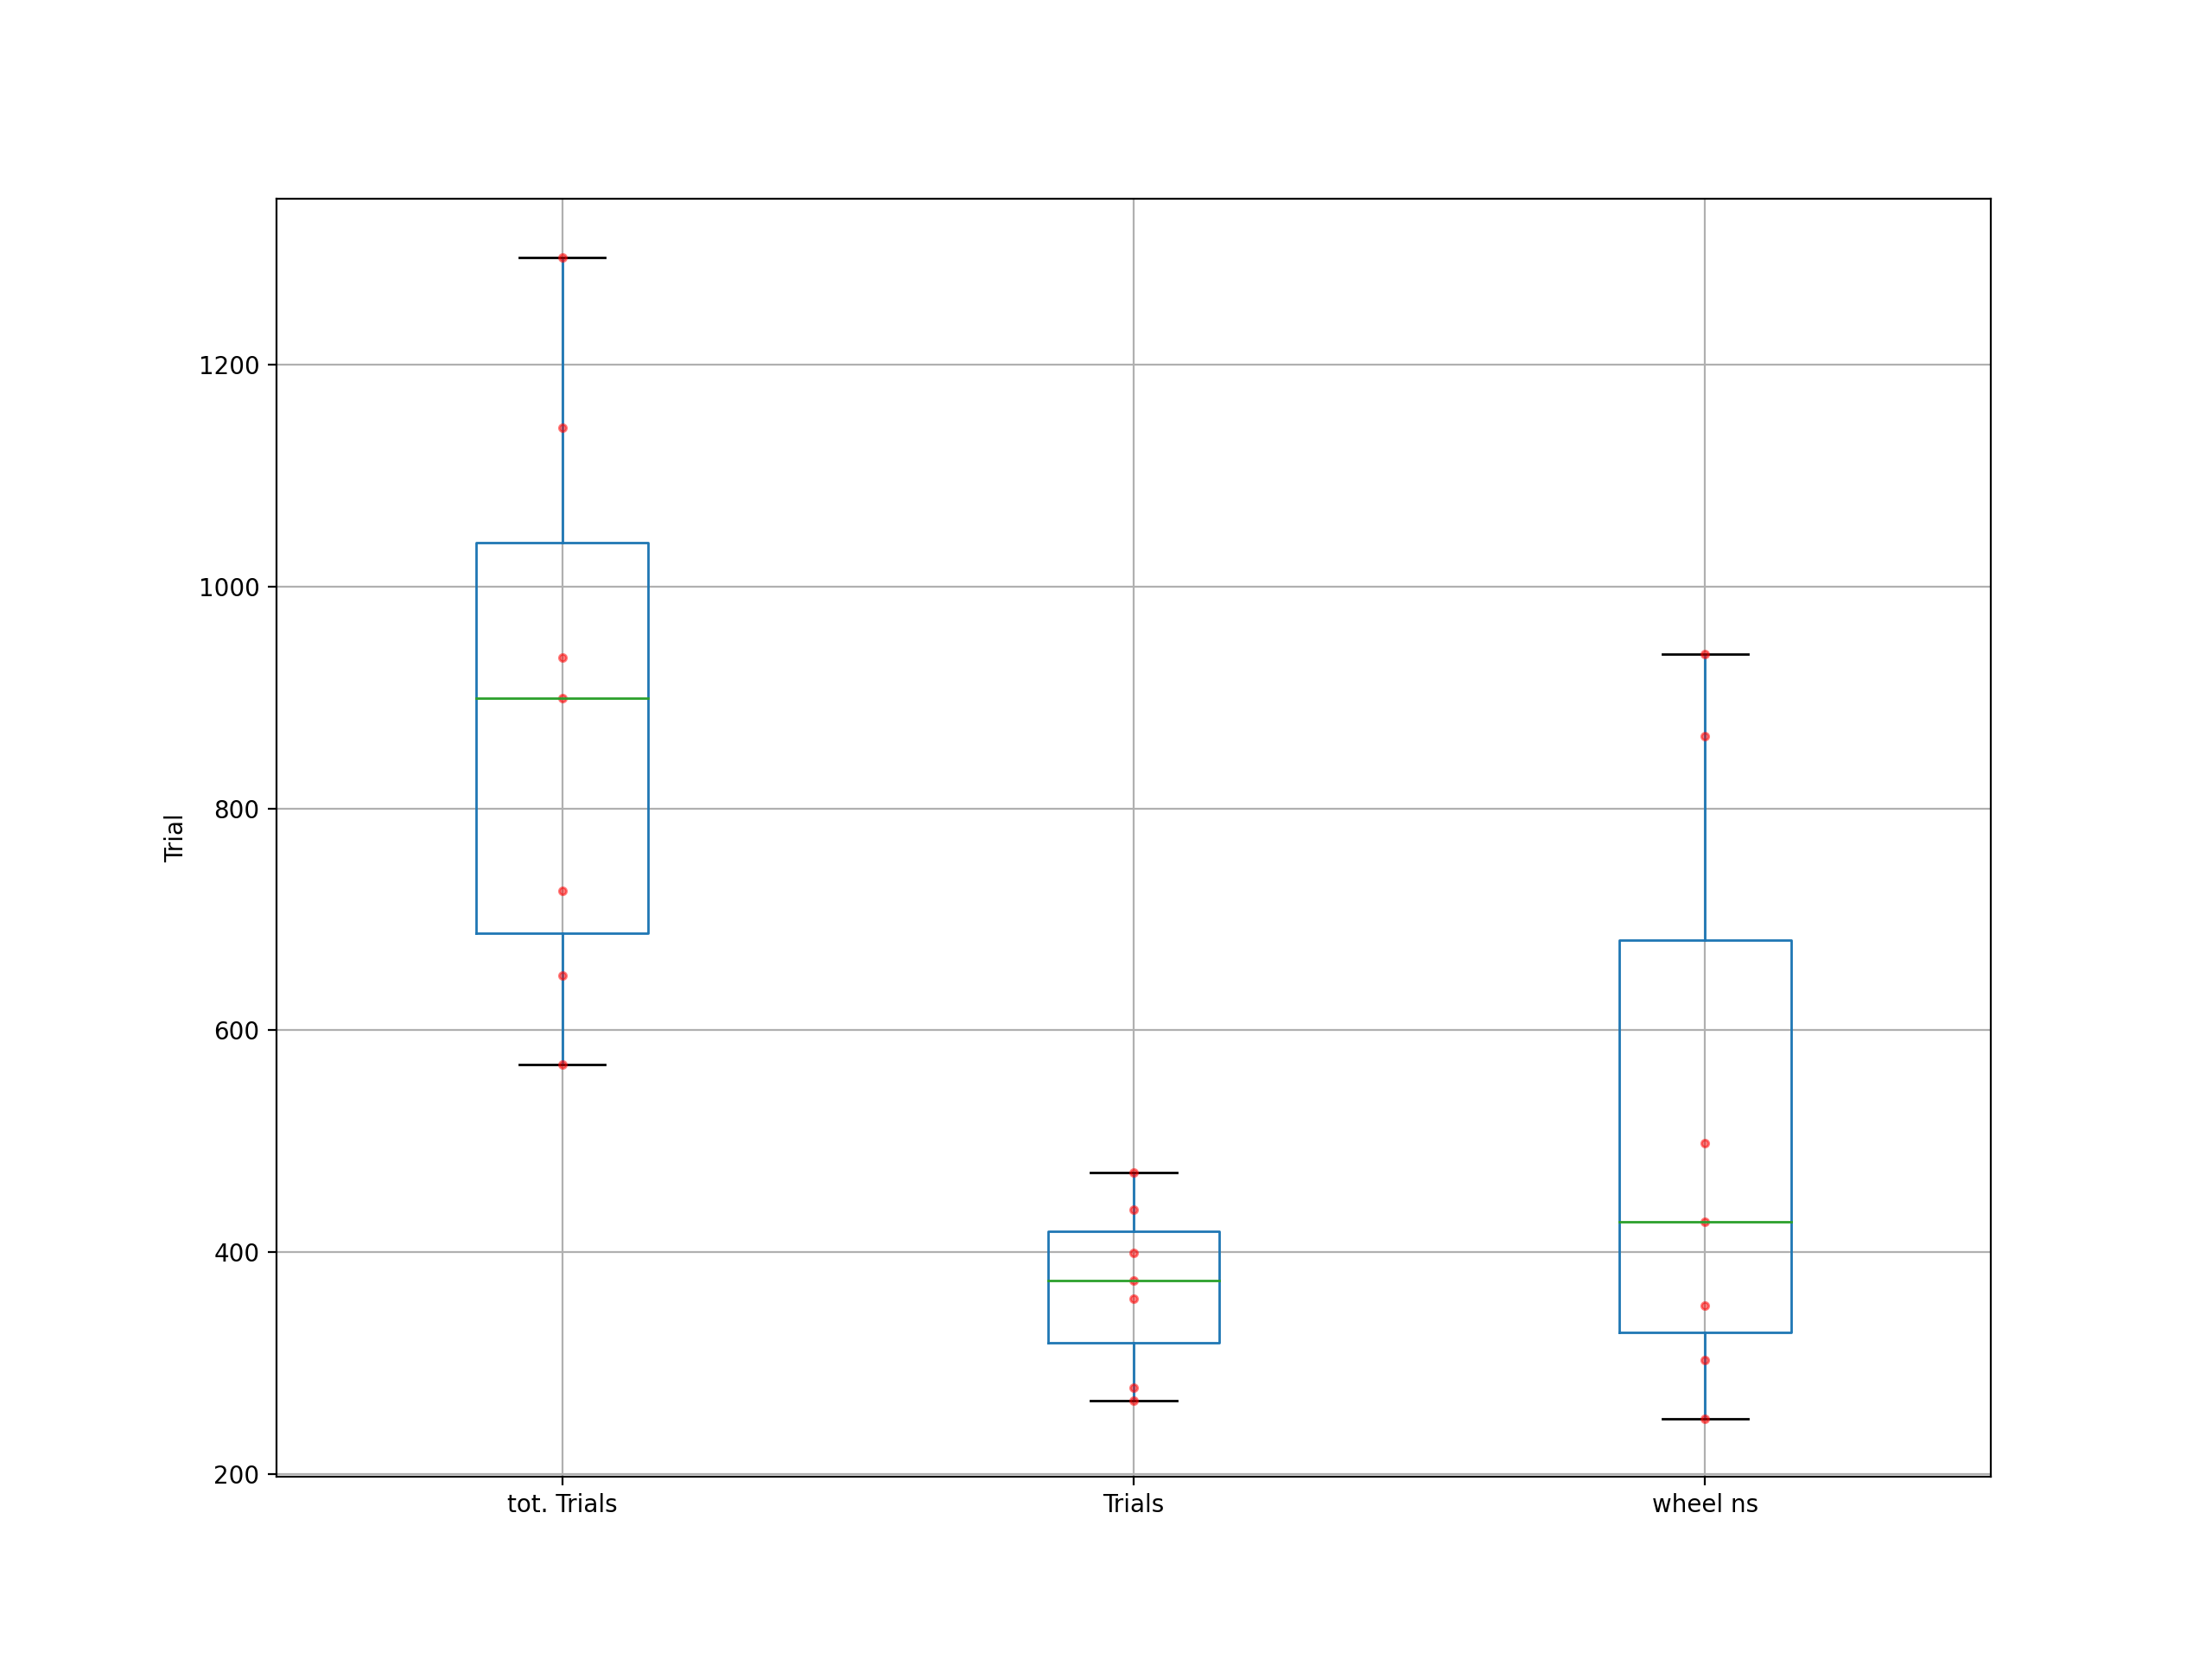

In [128]:
boxplot(session_info_df,['tot. Trials', 'Trials','wheel ns'],True)

<IPython.core.display.Javascript object>


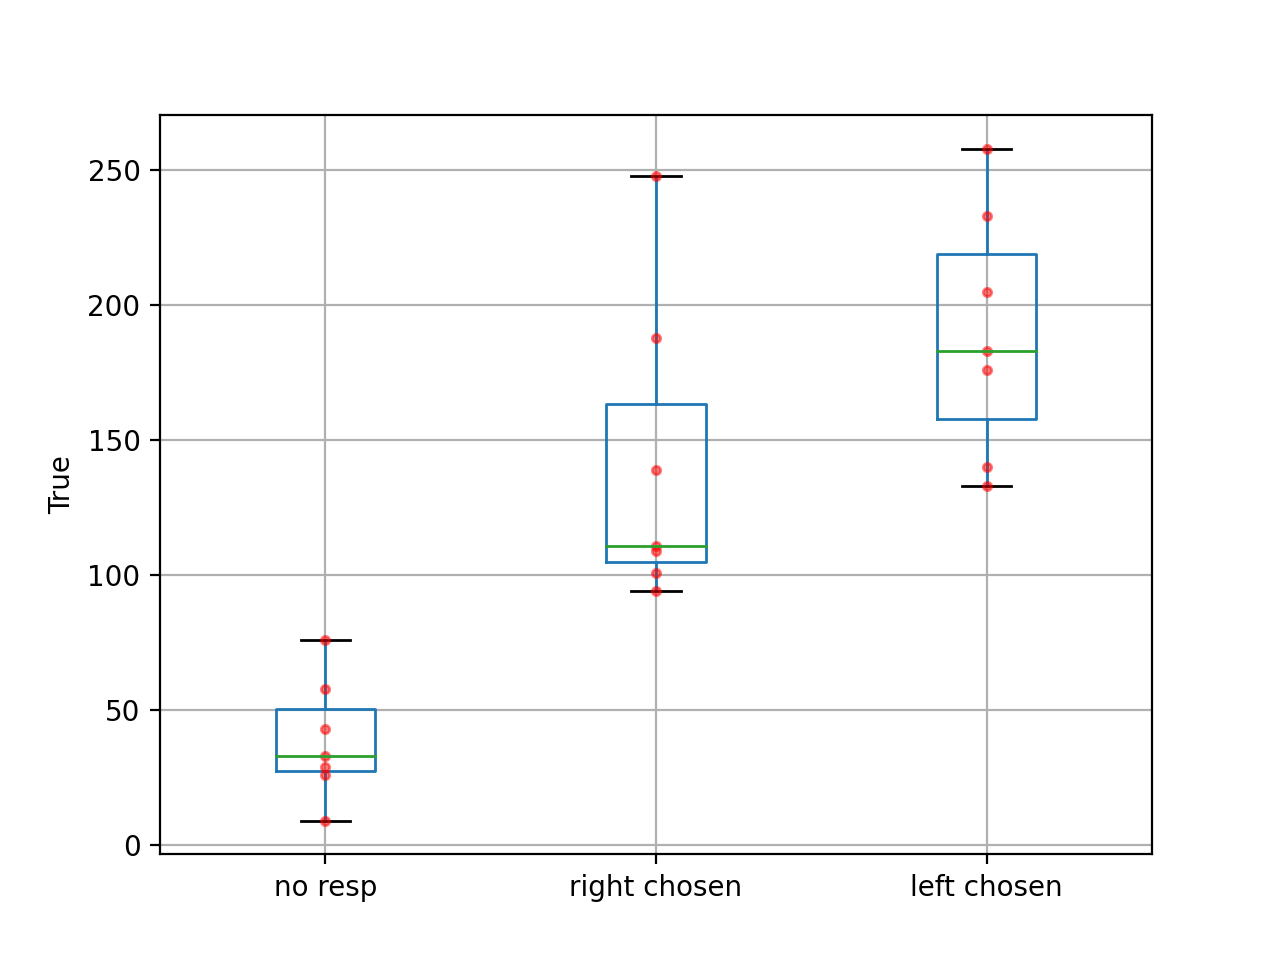

In [101]:
boxplot(session_info_df,['no resp','right chosen','left chosen'],True)

<IPython.core.display.Javascript object>


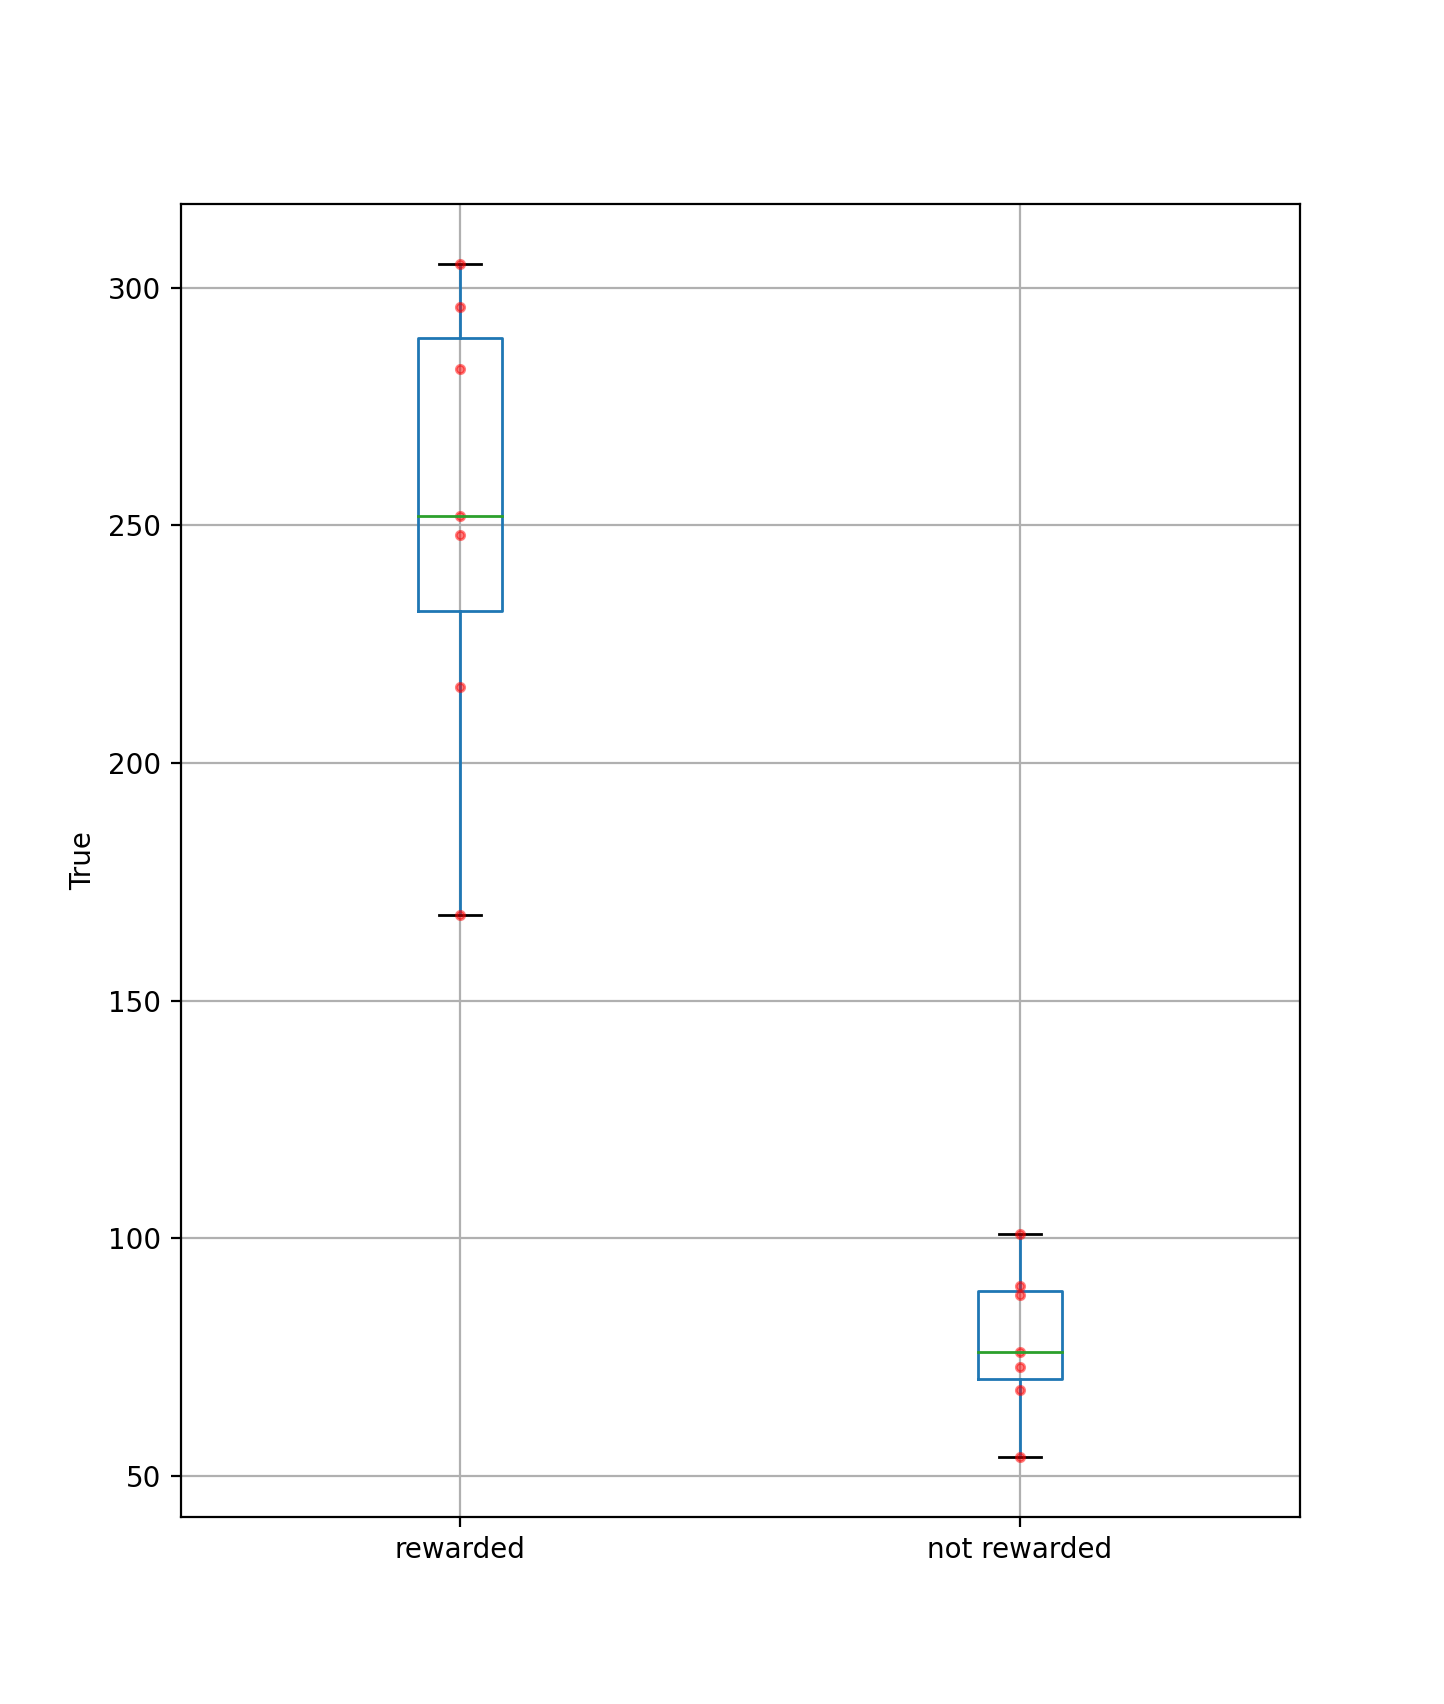

In [122]:
session_info_df['chosen'] = (session_info_df['right chosen'] + session_info_df['left chosen'])
session_info_df['rewarded'] = (session_info_df['right rewarded']+session_info_df['left rewarded'])
session_info_df['not rewarded'] = (session_info_df['chosen'] - session_info_df['rewarded'])

boxplot(session_info_df,['rewarded','not rewarded'],True)

<IPython.core.display.Javascript object>


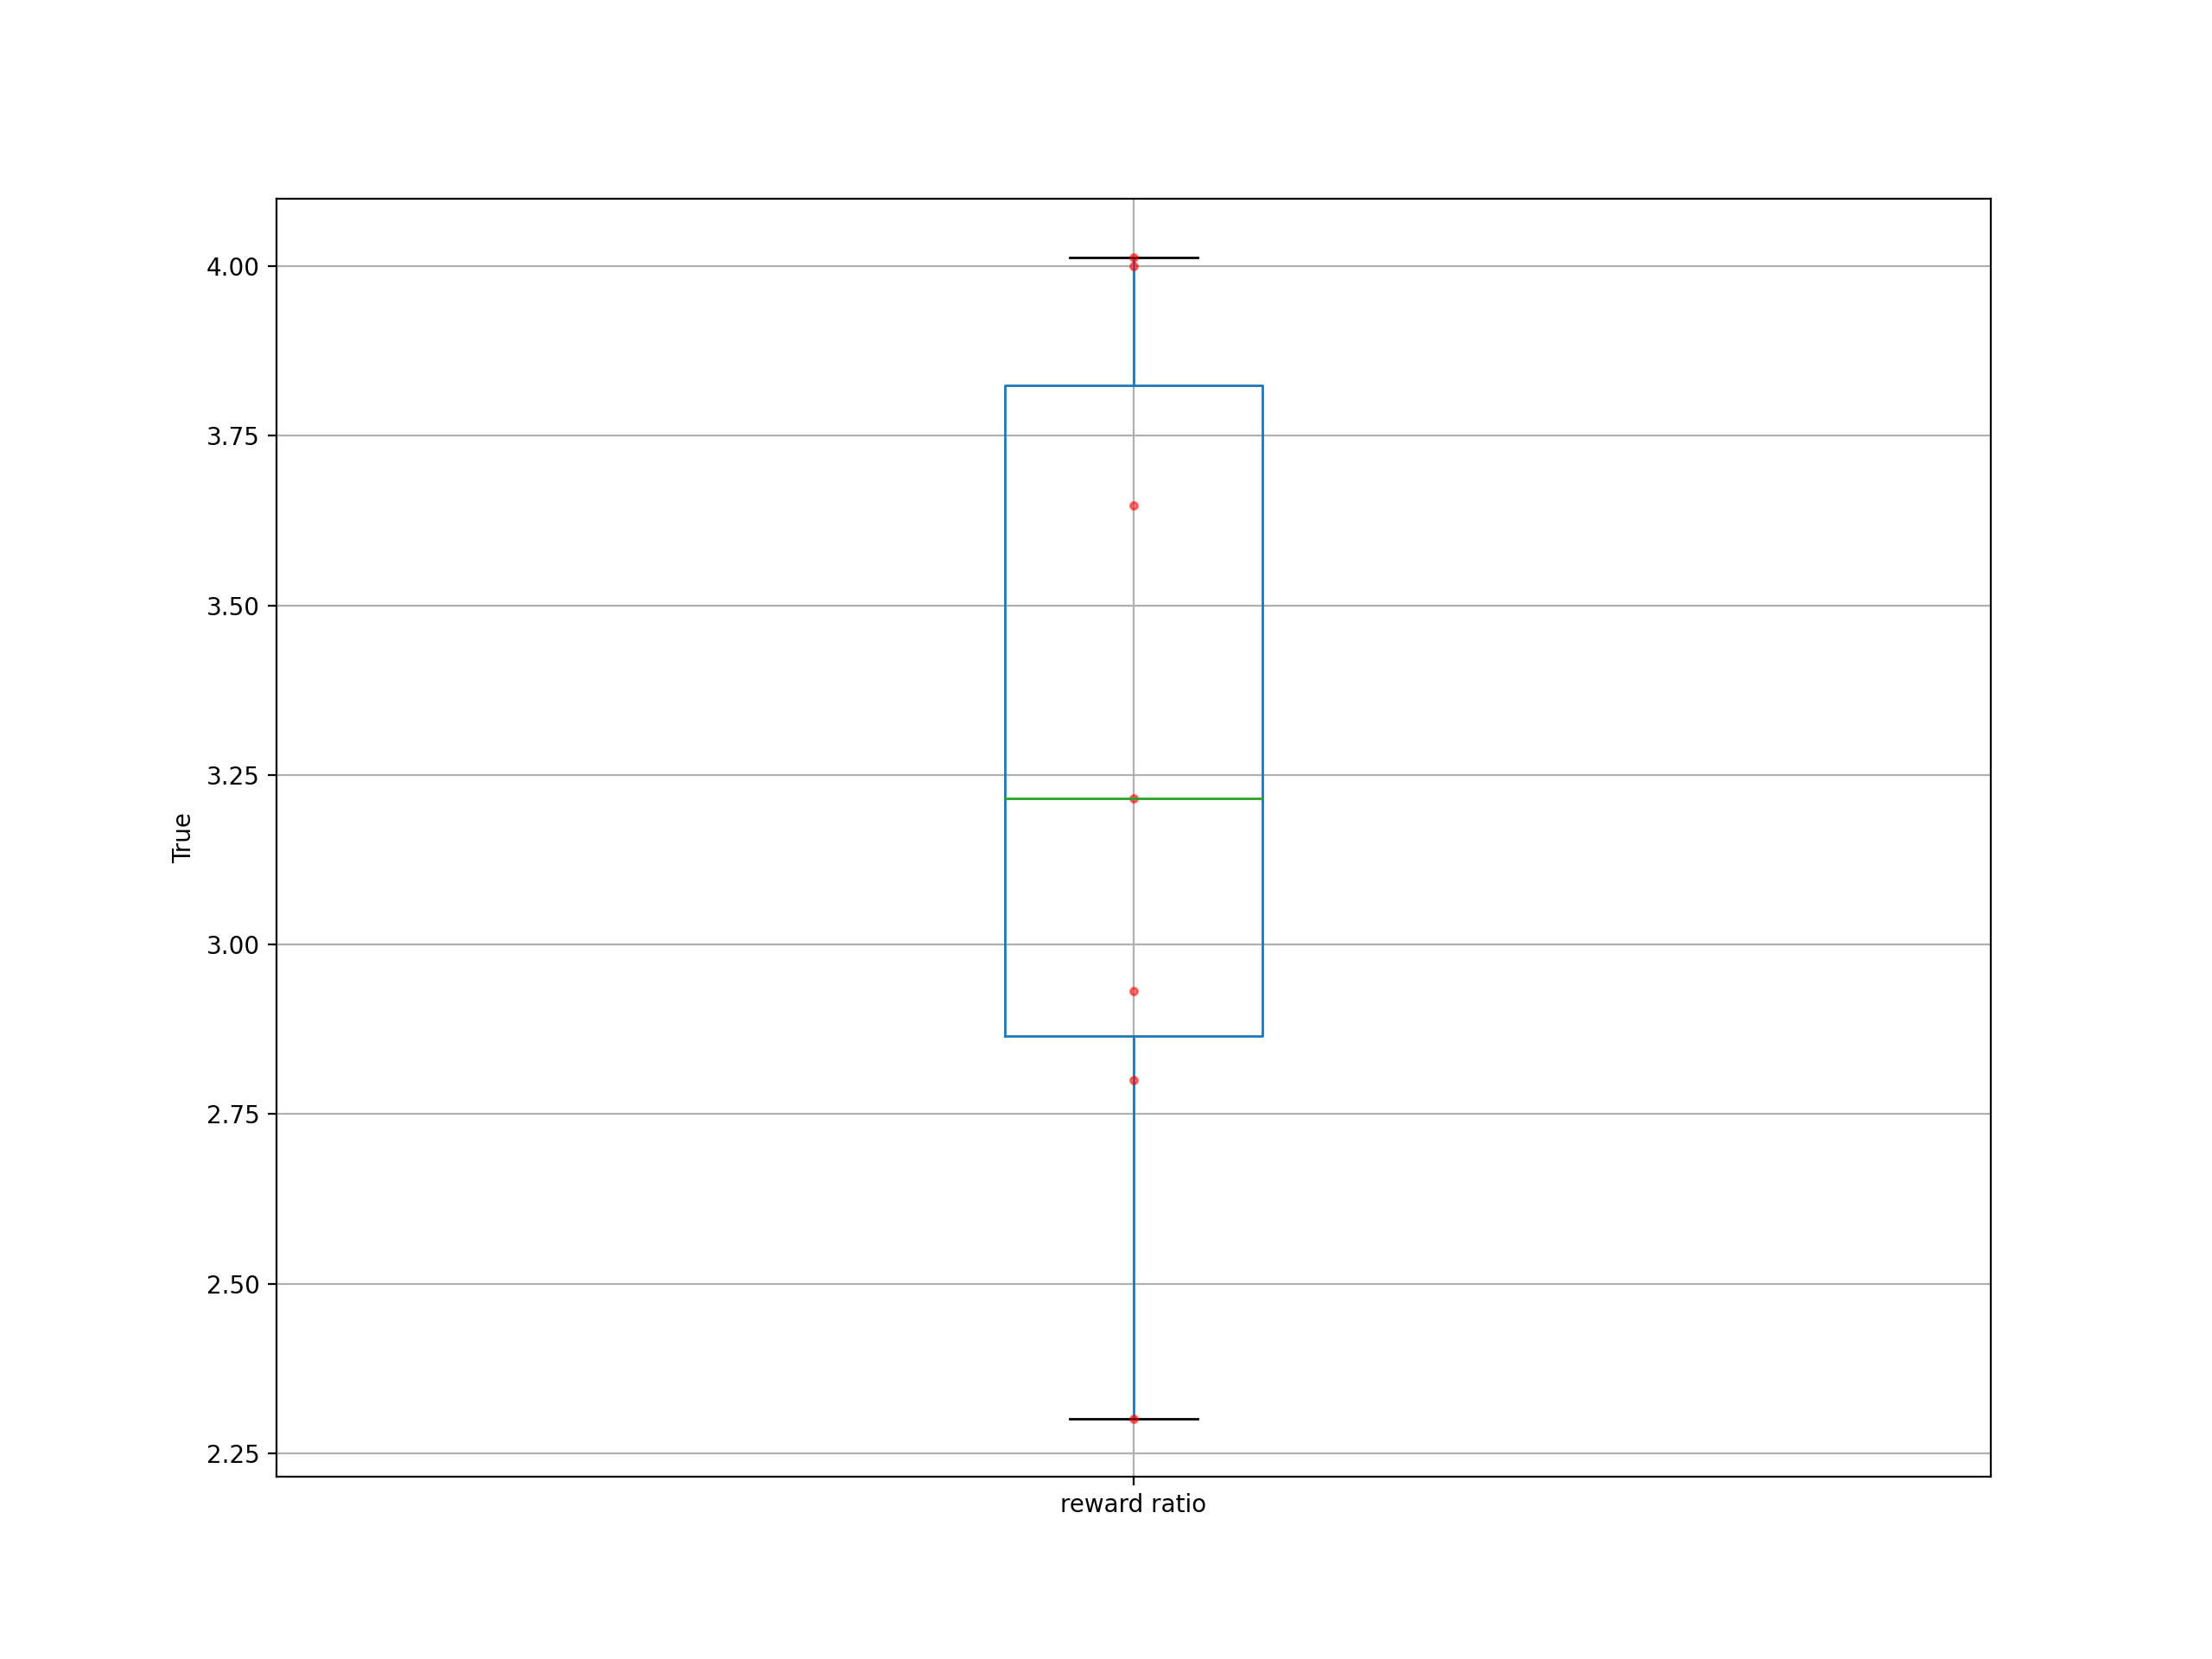

In [125]:
session_info_df['reward ratio'] = (session_info_df['rewarded'] / session_info_df['not rewarded'])
boxplot(session_info_df,['reward ratio'],True)

In [112]:

ratio = (session_info_df['rewarded'] / session_info_df['not rewarded'])
ratio = ratio/(ratio.max()-ratio.min())
ratio_norm = (ratio-ratio.mean())/ratio.std()
ratio_norm
#session_info_df['rewarded ratio'] = (session_info_df['chosen'] - session_info_df['rewarded'])


#boxplot(session_info_df,['rewarded ratio'],True)

1   -1.503266
2    1.125871
3    0.579589
4    1.146237
5   -0.529200
6   -0.087744
7   -0.731487
dtype: float64

In [110]:
ratio/(ratio.max()-ratio.min())

1    1.344425
2    2.336738
3    2.130555
4    2.344425
5    1.712065
6    1.878684
7    1.635717
dtype: float64

In [111]:
ratio.max()-ratio.min()

1.711788031723144

<IPython.core.display.Javascript object>


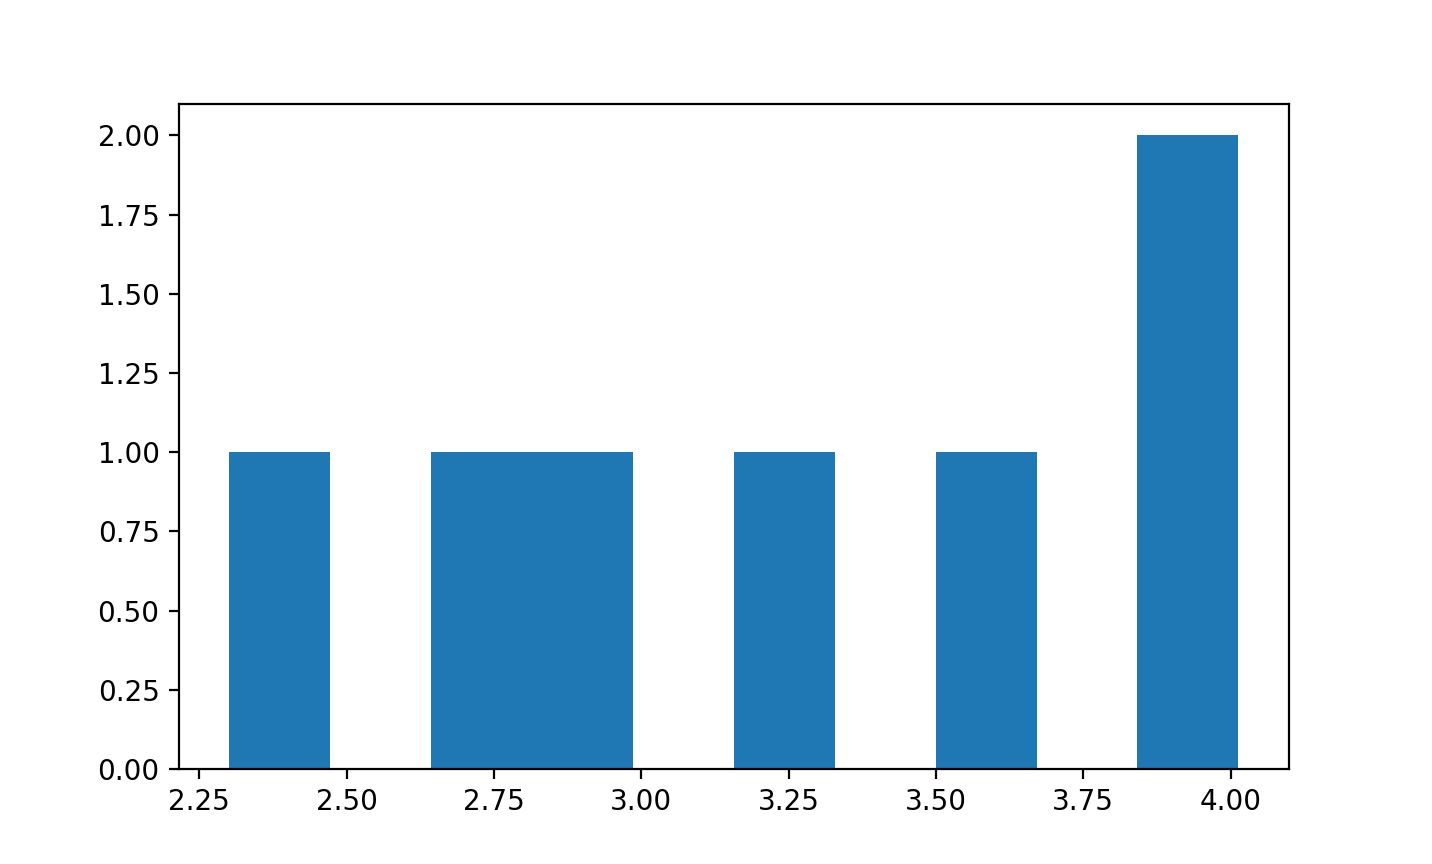

(array([1., 0., 1., 1., 0., 1., 0., 1., 0., 2.]),
 array([2.30136986, 2.47254867, 2.64372747, 2.81490627, 2.98608508,
        3.15726388, 3.32844268, 3.49962149, 3.67080029, 3.84197909,
        4.01315789]),
 <BarContainer object of 10 artists>)

In [121]:
ratio = (session_info_df['rewarded'] / session_info_df['not rewarded'])

plt.figure()
plt.hist(ratio)

---

---

# EDA

## generate tables

In [ ]:
def get_all_sessions_cluster_info(all_sessions):
    info_df = pd.DataFrame(columns=["session", "tot. clusters", "nr. good", "nr. mua", "nr. noise"])
    #info_df.set_index("session", inplace=True)
    for session in all_sessions:
        se_name = session.spikes.session
        cluster_count = session.spikes.clusters_df["group"].value_counts().values
        info = [se_name, cluster_count.sum()] + cluster_count.tolist()
        info_df.loc[info_df.shape[0] + 1]=info
    info_df.set_index("session", inplace=True, drop=True)
    return info_df

In [49]:
info_df = get_all_sessions_cluster_info([JG14_190621,JG18b_190828])
info_df

tot. clusters nr. good nr. mua nr. noise
session                                              
JG14_190621            167       92      61        14
JG18b_190828           385      187     174        24

## creating plots

In [68]:
def save_fig(session, name):
    folder = session.sync.folder+"/figures/all_figures"
    plt.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')
    plt.close()
    


def generate_plots(session):
    %matplotlib inline
    %matplotlib inline
    """
    #hist and fit
    plt.figure()
    spikes_obj.plt_trial_hist_and_fit(session.spikes.selected_trials_df.loc[:,'length'])
    save_fig(session, 'hist_fit')
    save_fig(session, 'hist_fit')
    
    # trial length
    plt.figure()
    plt.plot(JG14_190621.spikes.selected_trials_df.loc[:,'length'])
    plt.ylabel('length [ms]')
    plt.xlabel('trial')
    save_fig(session, 'trial_length')
    
    # cluster histogram
    session.spikes.plt_all_cluster_spikes_hist()
    save_fig(session, 'cluster_hist')
    
    # plott all isi for good clustes only focus between selected trials
    start = session.spikes.selected_trials_df.loc[0,'start']
    end = session.spikes.selected_trials_df.iloc[-1]['end']

    for cluster, row in session.spikes.clusters_df.loc[session.spikes.clusters_df['group']=='good'].iterrows():
        a = row['spikes']
        session.spikes.plot_single_neuron_isis(a[np.logical_and(a>=start, a<=end)],cluster)
        save_fig(session, 'isi_'+str(cluster))
        
    # spike trains
    for cluster in session.spikes.clusters_df.loc[session.spikes.clusters_df['group']=='good'].index:
        session.spikes.plt_spike_train(cluster)
        save_fig(session, 'spk_train_'+str(cluster))
    """    
    # spike train + hist all trials
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist_all_events(cluster, session.spikes.selected_trials_df, 'cue', 2000)
        save_fig(session, 'spk_train_hist_all-events_'+str(cluster))
    """
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist_all_events(cluster, session.spikes.selected_trials_df, 'reward', 2000)
        save_fig(session, 'spk_train_hist_all-events_reward-centered_'+str(cluster))
    
    """
    # plott reward at specific trials
    
    # get gambl side
    if session.spikes.gamble_side == 'right':
        save='left'
        gamble='right'
    else:
        save='right'
        gamble='left'
    
    #spike train + hist reward specific events
    # reward right
    selected_trials = session.spikes.selected_trials_df[(session.spikes.selected_trials_df[gamble])&(session.spikes.selected_trials_df['reward_given'])]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_gamble_reward_'+str(cluster))
    
    # reward left
    selected_trials = session.spikes.selected_trials_df[(session.spikes.selected_trials_df[save])&(session.spikes.selected_trials_df['reward_given'])]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_save_reward_'+str(cluster))
    
    # not rewarded
    selected_trials = session.spikes.selected_trials_df[(session.spikes.selected_trials_df[gamble])&(np.invert(session.spikes.selected_trials_df['reward_given']))]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_gamble_no-reward_'+str(cluster))
    
    # reward left
    selected_trials = session.spikes.selected_trials_df[(session.spikes.selected_trials_df[save])&(np.invert(session.spikes.selected_trials_df['reward_given']))]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_save_no-reward_'+str(cluster))
        
    
    # all reward
    selected_trials = session.spikes.selected_trials_df[session.spikes.selected_trials_df['reward_given']]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_reward_'+str(cluster))
        
    # all right
    selected_trials = session.spikes.selected_trials_df[session.spikes.selected_trials_df[gamble]]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_gamble_'+str(cluster))

    # all left
    selected_trials = session.spikes.selected_trials_df[session.spikes.selected_trials_df[save]]
    for cluster in session.spikes.clusters_df.index:
        fig, ax = session.spikes.plt_spike_train_hist(cluster, selected_trials, 'reward', 2000)
        save_fig(session, 'spk_train_hist_save_'+str(cluster))
        
    session.spikes.create_report()


In [73]:
generate_plots(JG14_190621)

In [125]:
generate_plots(JG18b_190828)

[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom


[(0.25, 61), (0.125, 161)]


/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  # set ticks top and bottom
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 C

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:600: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)
/Users/max/Google Drive/3

In [129]:
JG18b_190828.spikes.generate_report()

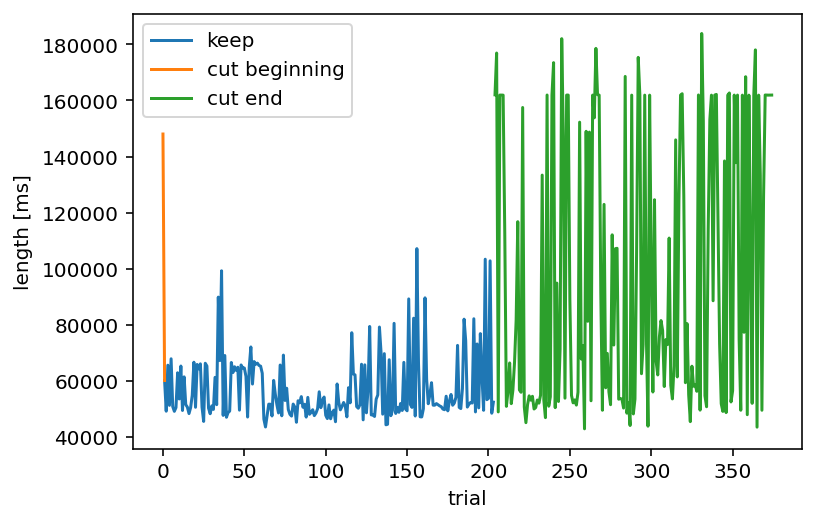

In [427]:
plt.figure()
plt.plot(JG18b_190828.spikes.selected_trials_df.loc[:,'length'],label='keep')
plt.plot(JG18b_190828.spikes.good_trials_df.loc[0:1,'length'],label='cut beginning')
plt.plot(JG18b_190828.spikes.good_trials_df.loc[204:,'length'],label='cut end')
plt.ylabel('length [ms]')
plt.xlabel('trial')
plt.legend()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram of Trial Length $\\mu=$57035.59, $\\sigma=$11603.4673'}, xlabel='Trial Length [ms]', ylabel='Probability density'>)

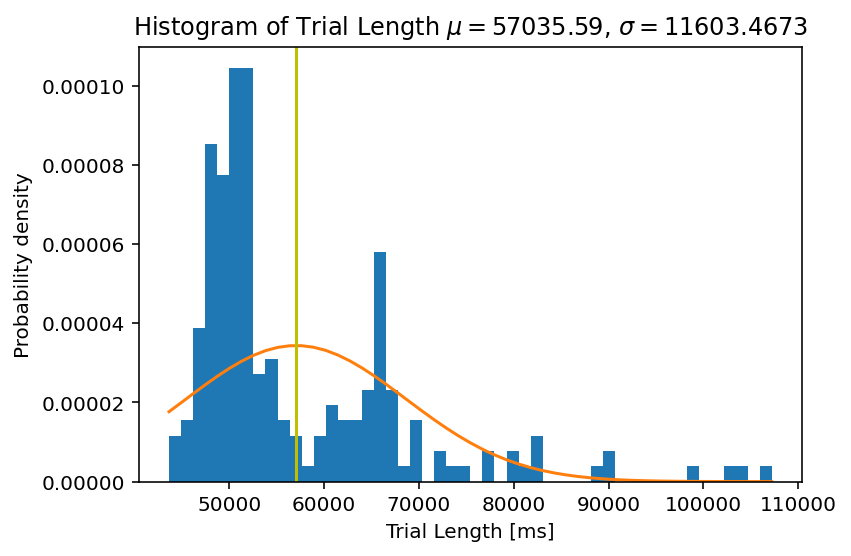

In [430]:
spikes_obj.plt_trial_hist_and_fit(JG18b_190828.spikes.selected_trials_df.loc[:,'length'])

<IPython.core.display.Javascript object>


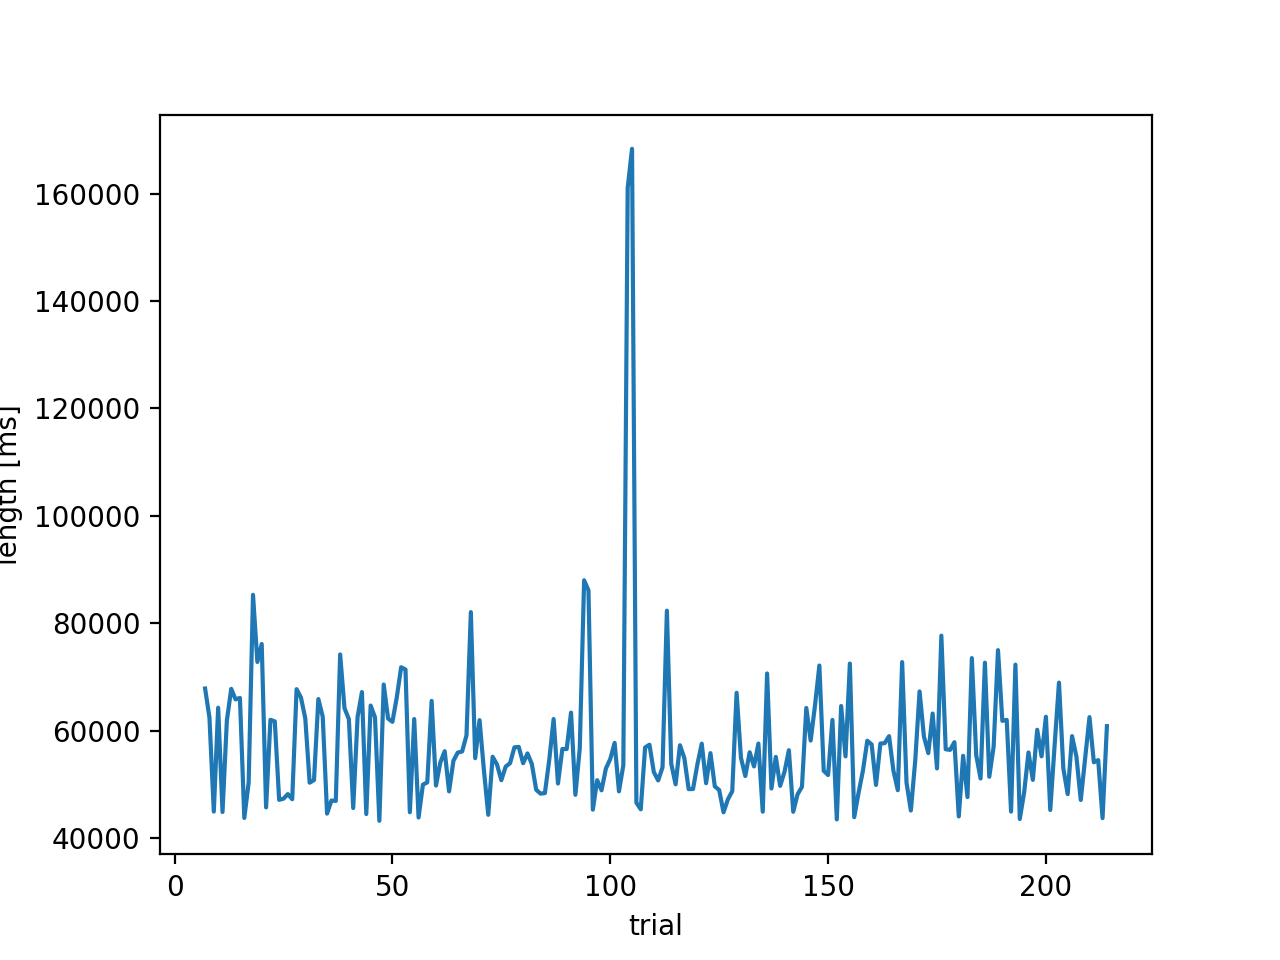

Text(0.5, 0, 'trial')

In [10]:
plt.figure()
plt.plot(JG14_190621.spikes.selected_trials_df.loc[:,'length'])
plt.ylabel('length [ms]')
plt.xlabel('trial')

<IPython.core.display.Javascript object>


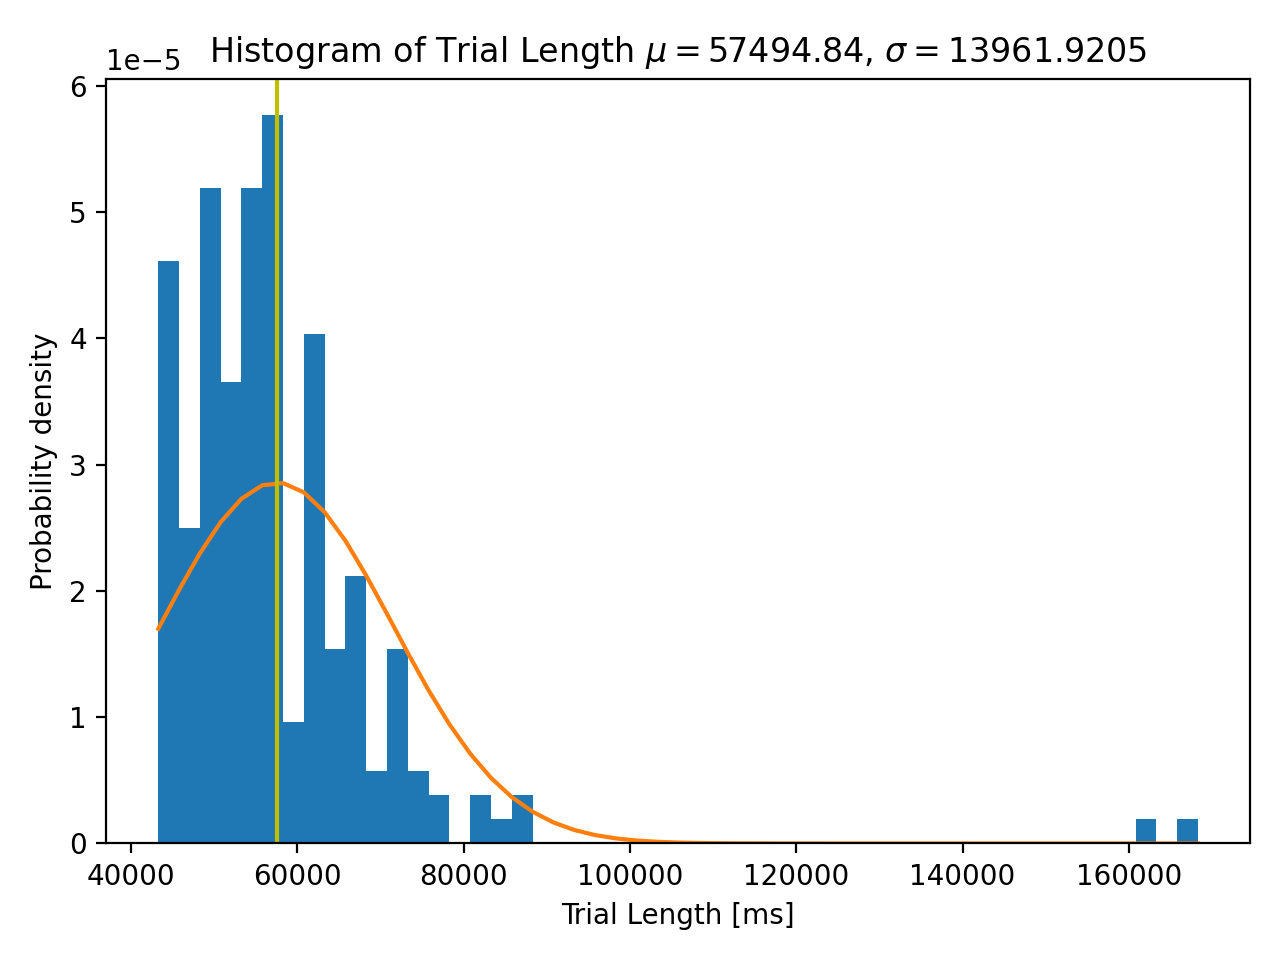

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Histogram of Trial Length $\\mu=$57494.84, $\\sigma=$13961.9205'}, xlabel='Trial Length [ms]', ylabel='Probability density'>)

In [11]:
spikes_obj.plt_trial_hist_and_fit(JG14_190621.spikes.selected_trials_df.loc[:,'length'])

In [30]:
sum_df = pd.DataFrame(columns=['session','good','mua','noise'])
sum_df.loc[sum_df.shape[0] + 1] = ['JG14_190621']+list(JG14_190621.spikes.clusters_df['group'].value_counts())
sum_df.loc[sum_df.shape[0] + 1] = ['JG18b_190828']+list(JG18b_190828.spikes.clusters_df['group'].value_counts())
sum_df

session good  mua noise
1   JG14_190621   92   61    14
2  JG18b_190828  187  174    24

<IPython.core.display.Javascript object>


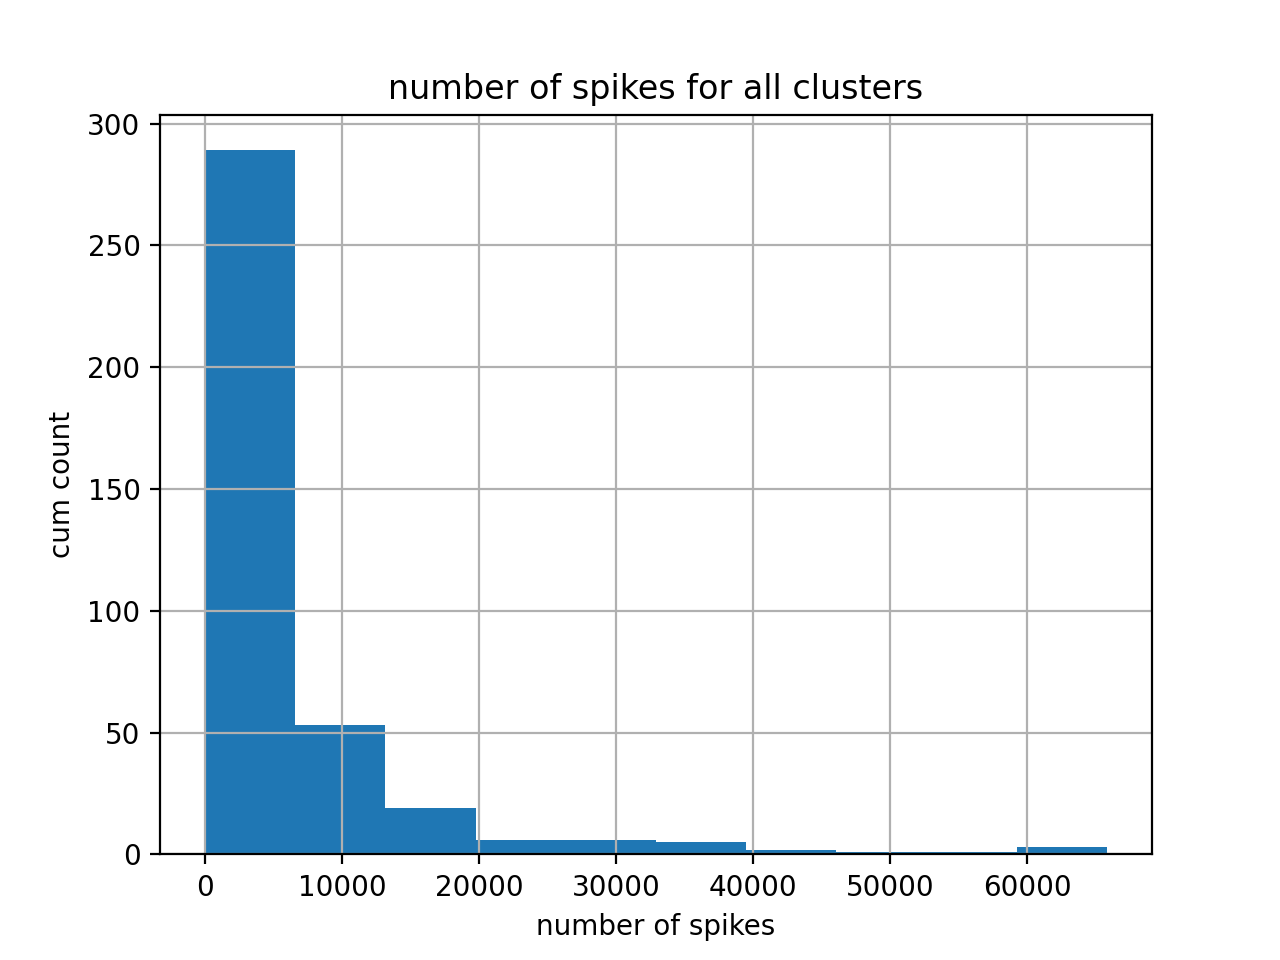

In [41]:
plt.figure()
(JG18b_190828.spikes.clusters_df['n_spikes']).hist()
plt.xlabel('number of spikes')
plt.ylabel('cum count')
plt.title('number of spikes for all clusters')
plt.show()

In [79]:
(JG18b_190828.spikes.all_trials_df["end"].max()/ 20000)/60

26.898205833333336

In [77]:
 JG18b_190828.spikes.clusters_df.loc[JG18b_190828.spikes.clusters_df['group']=="good"]['n_spikes'].max()

65827

In [80]:
(JG14_190621.spikes.all_trials_df["end"].max()/ 20000)/60

18.7088

In [78]:
 JG14_190621.spikes.clusters_df.loc[JG14_190621.spikes.clusters_df['group']=="good"]['n_spikes'].max()

21290

In [52]:
fig, ax = plt.subplots()

trial_length_samplingrate = self.all_trials_df["end"].max()
trial_length_seconds = trial_length_samplingrate / 20000

data = self.clusters_df[['group','n_spikes']].copy()
data['frequency'] = data['n_spikes']/trial_length_seconds

(data.loc[data['group']=='good','frequency']).hist(alpha=0.6,label='good clusters')
(data.loc[data['group']=='mua','frequency']).hist(alpha=0.4,label='MUA clusters')
(data.loc[data['group']=='noise','frequency']).hist(label='noise clusters')

ax.legend()

ax.legend()
ax.set_xlabel('distribution of spikes frequency across cluster types')
ax.set_ylabel('cum count')

cluster id
0       4457
6      17895
7       1450
10      4242
11        13
       ...  
391     1496
393      818
397     4569
398    11666
399    10852
Name: n_spikes, Length: 200, dtype: int64

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'number of spikes for specific clusters'}, xlabel='number of spikes', ylabel='cum count'>)

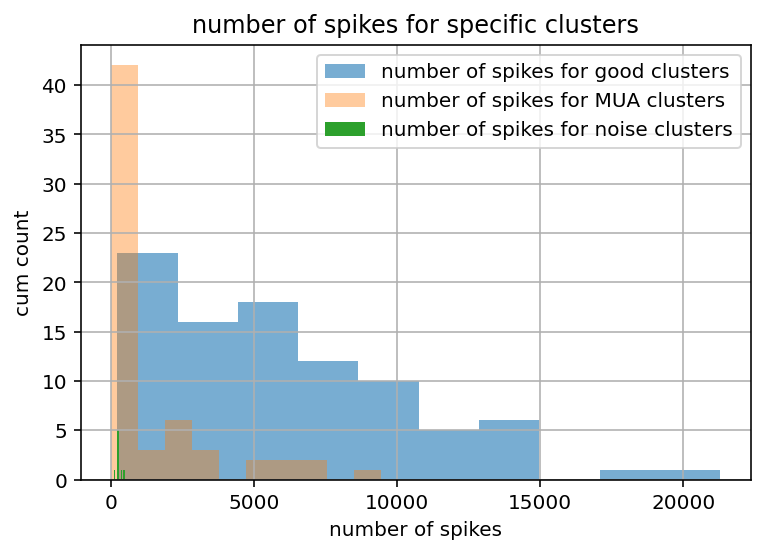

In [431]:
JG14_190621.spikes.plt_all_cluster_spikes_hist()

<IPython.core.display.Javascript object>


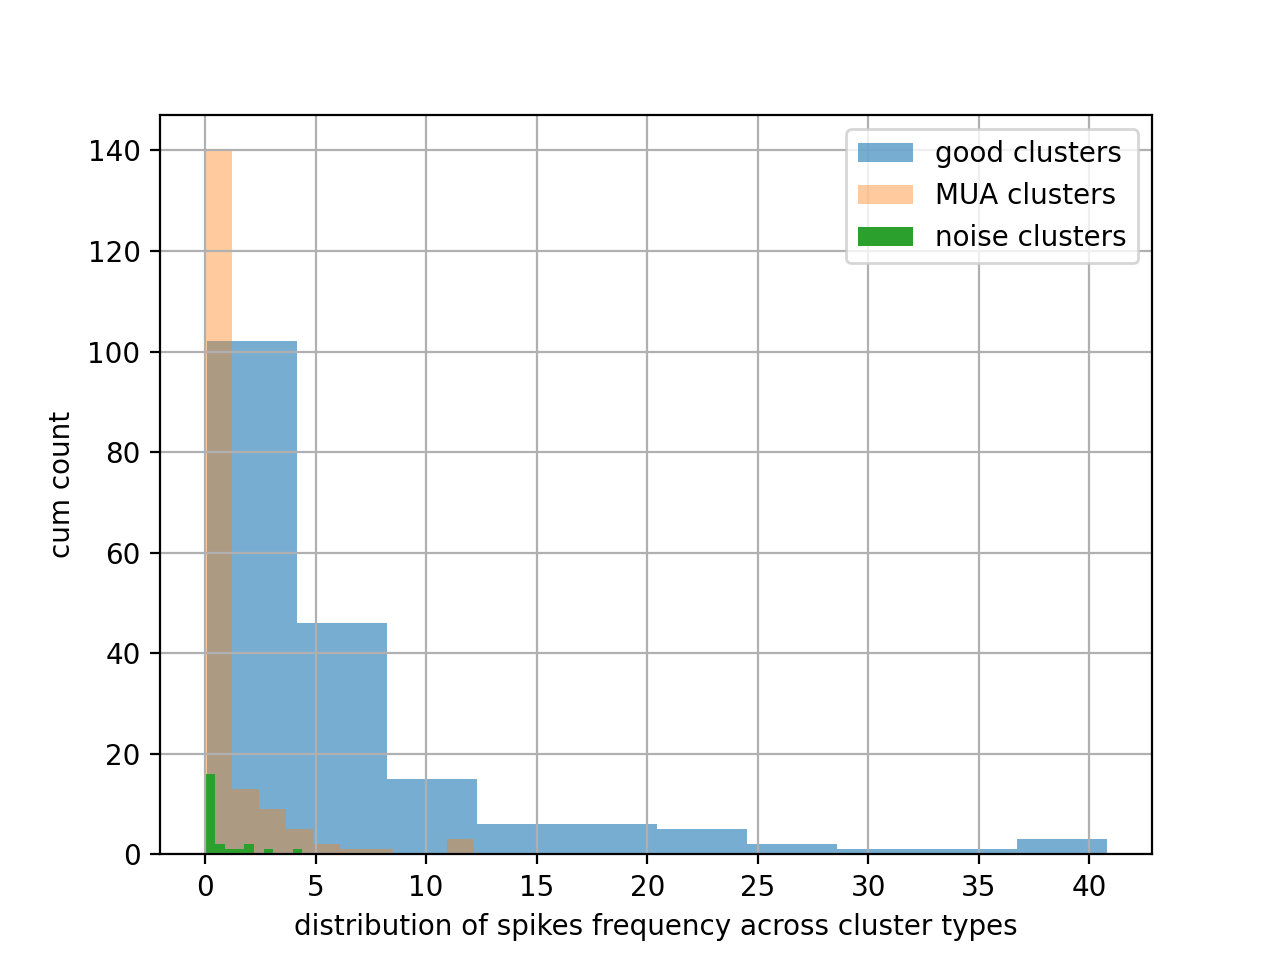

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='distribution of spikes frequency across cluster types', ylabel='cum count'>)

In [71]:
JG18b_190828.spikes.plt_all_cluster_spikes_hist()
#save_fig(JG18b_190828, 'cluster_hist')

In [62]:
trial_length_samplingrate = JG14_190621.spikes.all_trials_df["end"].max()
trial_length_seconds = trial_length_samplingrate / 2000

data = JG14_190621.spikes.clusters_df[['group','n_spikes']].copy()
data['n_spike'] = data['n_spikes']/trial_length_seconds
data

group  n_spikes   n_spike
cluster id                          
0           good      1850  0.164807
1           good      5787  0.515533
2            mua      6372  0.567647
3           good      2696  0.240172
4           good      4641  0.413442
...          ...       ...       ...
203          mua      1654  0.147346
204         good      6466  0.576021
206          mua      2445  0.217812
209         good      4392  0.391260
214         good     12953  1.153913

[167 rows x 3 columns]

<IPython.core.display.Javascript object>


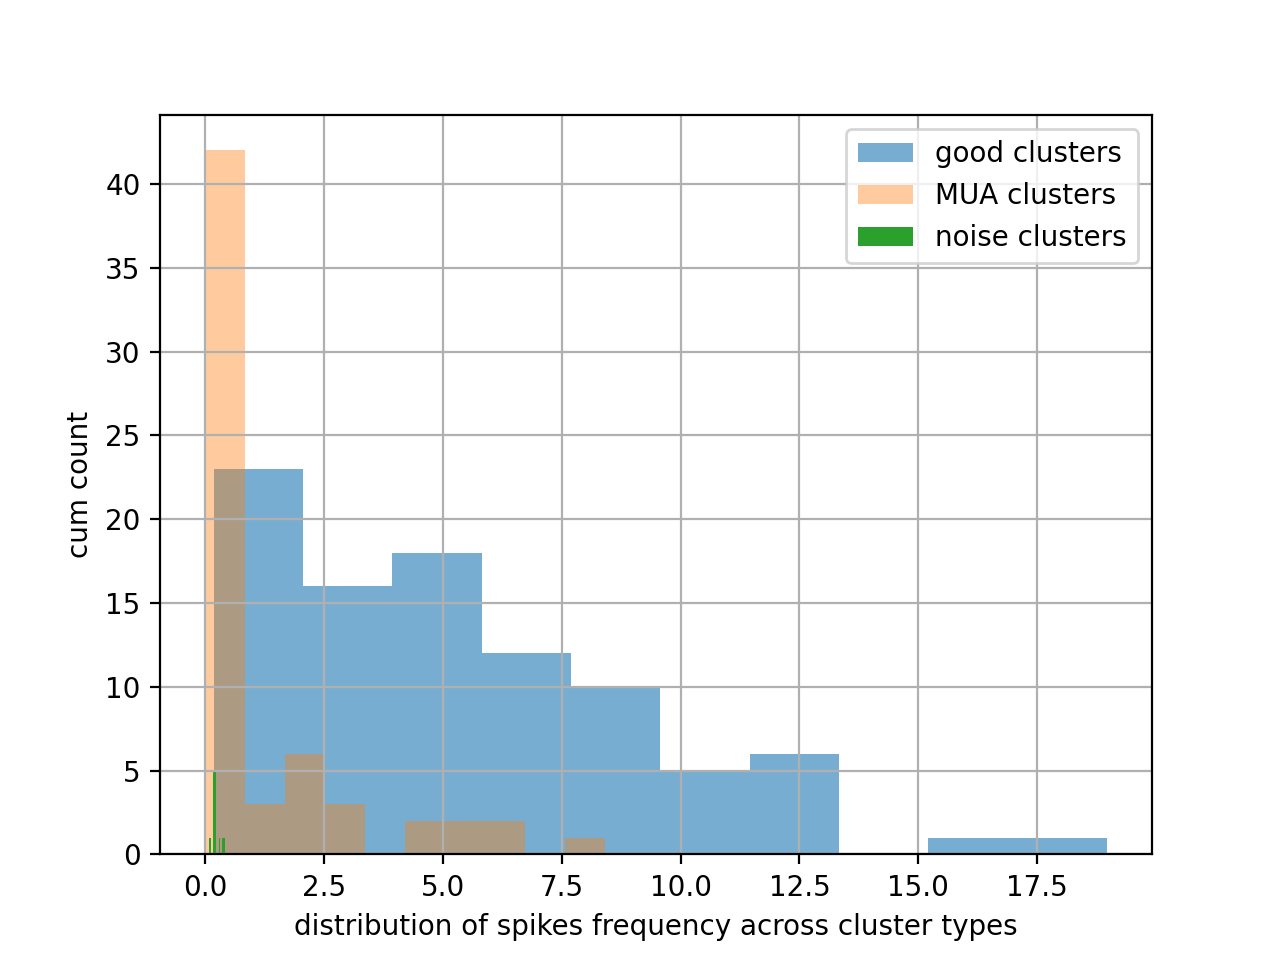

Text(0, 0.5, 'cum count')

In [66]:
fig, ax = plt.subplots()

trial_length_samplingrate = JG14_190621.spikes.all_trials_df["end"].max()
trial_length_seconds = trial_length_samplingrate / 20000

data = JG14_190621.spikes.clusters_df[['group','n_spikes']].copy()
data['frequency'] = data['n_spikes']/trial_length_seconds

(data.loc[data['group']=='good','frequency']).hist(alpha=0.6,label='good clusters')
(data.loc[data['group']=='mua','frequency']).hist(alpha=0.4,label='MUA clusters')
(data.loc[data['group']=='noise','frequency']).hist(label='noise clusters')

ax.legend()

ax.legend()
ax.set_xlabel('distribution of spikes frequency across cluster types')
ax.set_ylabel('cum count')

In [ ]:
plt.figure()

(JG14_190621.spikes.clusters_df.loc[JG14_190621.spikes.clusters_df['KSLabel']=='good','n_spikes']).hist(alpha=0.6,label='number of spikes for good clusters')

plt.legend()

plt.legend()
plt.xlabel('number of spikes')
plt.ylabel('cum count')
plt.title('number of spikes for specific clusters')
plt.show()

<IPython.core.display.Javascript object>


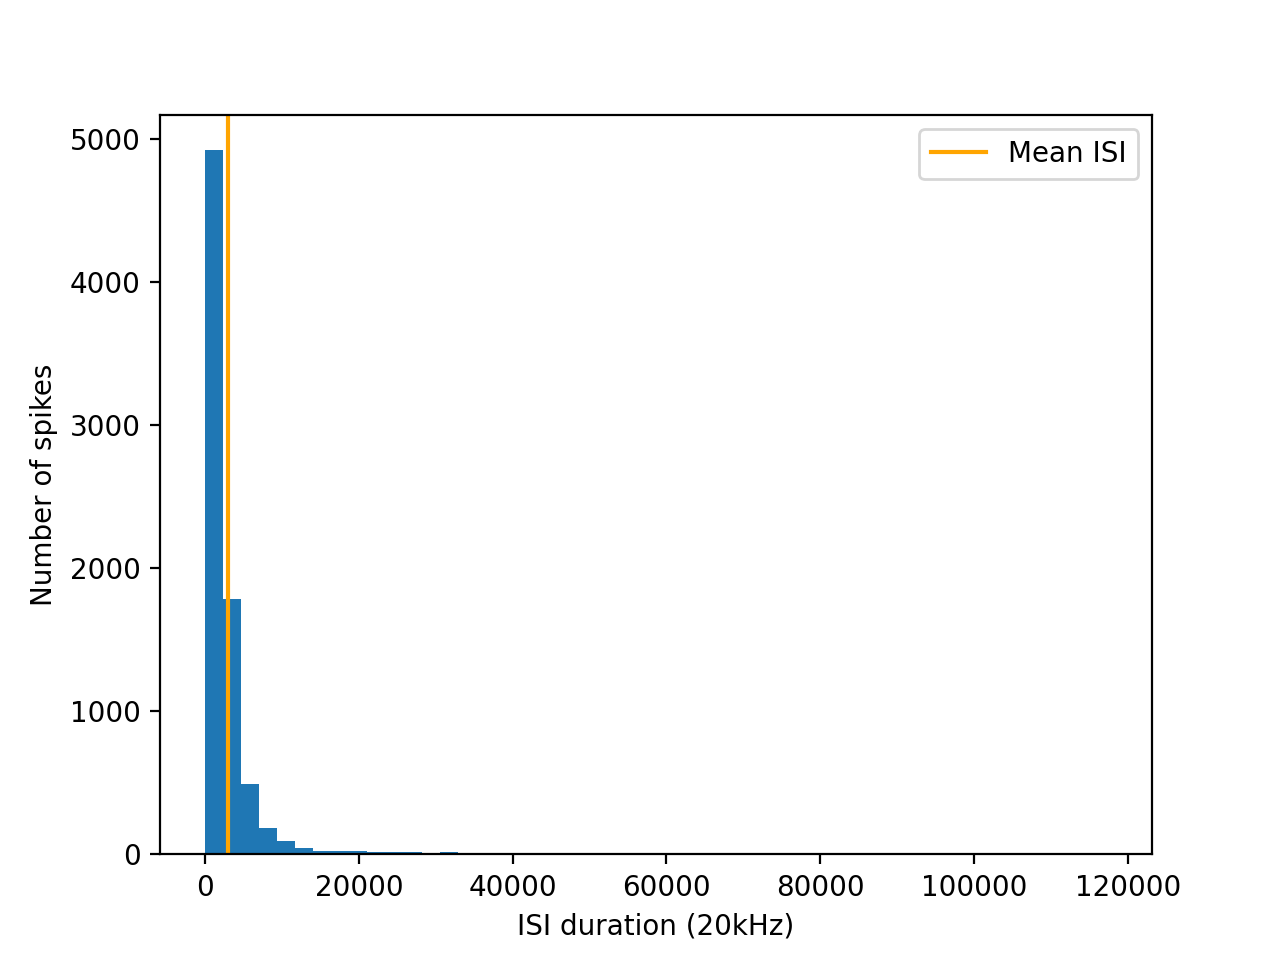

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='ISI duration (20kHz)', ylabel='Number of spikes'>)

In [334]:
JG14_190621.spikes.plot_single_neuron_isis((JG14_190621.spikes.clusters_df.loc[79,'spikes']),79)

<IPython.core.display.Javascript object>


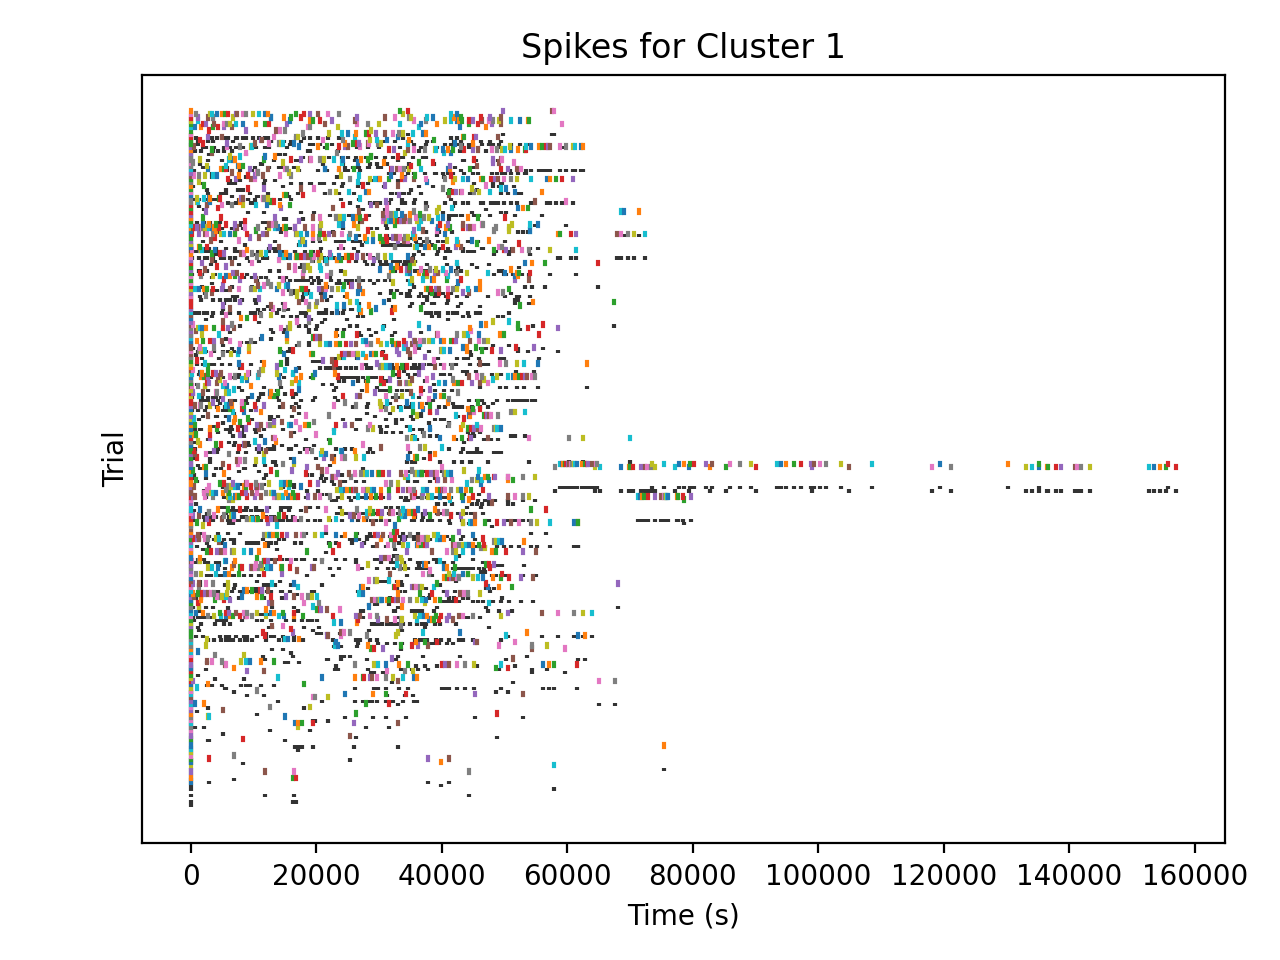

In [110]:
cluster = JG18b_190828.spikes.spikes_df[JG18b_190828.spikes.spikes_df.loc[:]['cluster'] == 1]['spike_times']
fig, ax = JG18b_190828.spikes.plt_spike_train(cluster, JG18b_190828.spikes.selected_trials_df)
plt.show()

<IPython.core.display.Javascript object>


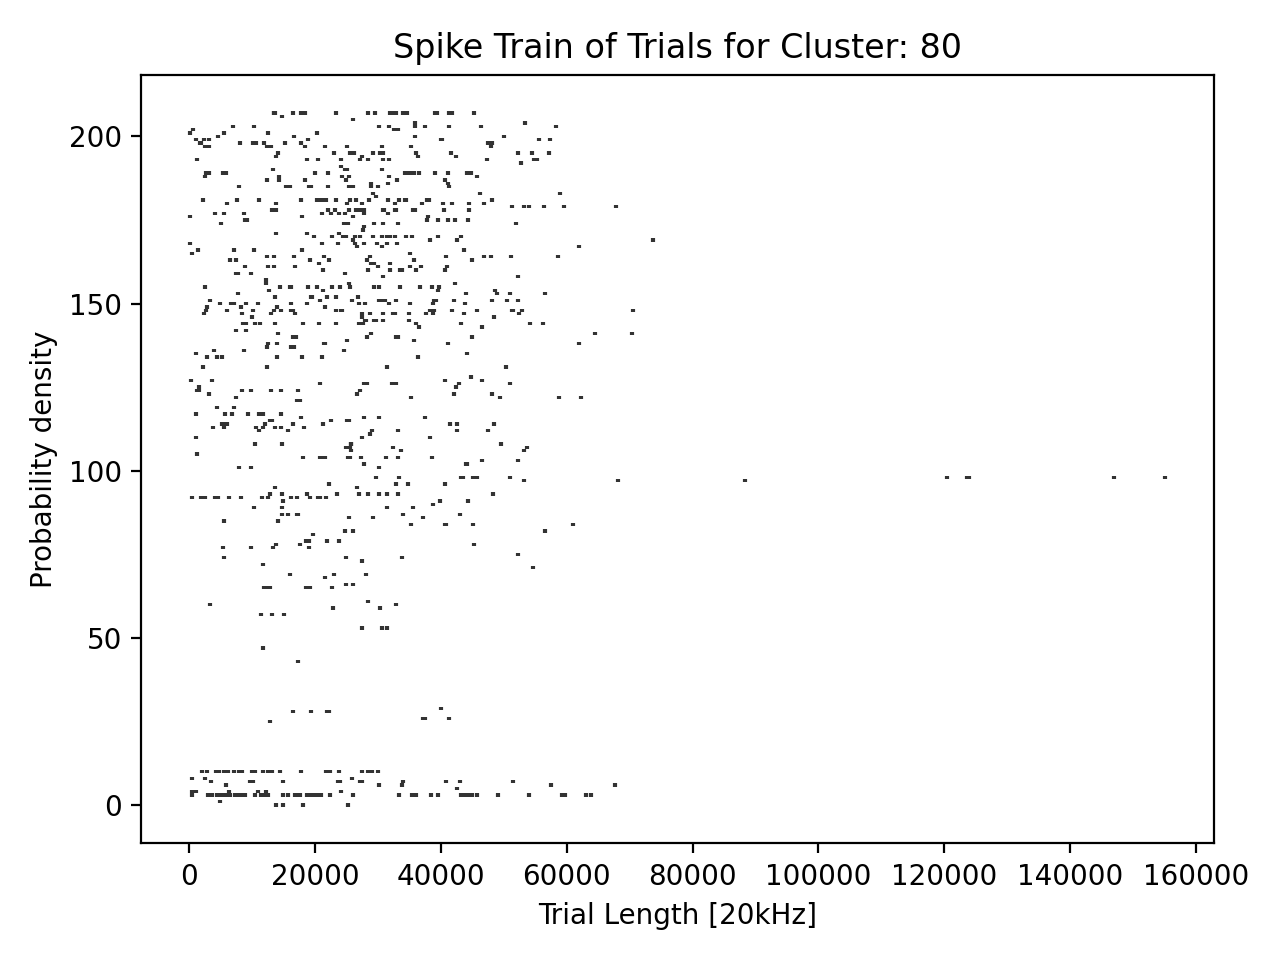

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Spike Train of Trials for Cluster: 80'}, xlabel='Trial Length [20kHz]', ylabel='Probability density'>)

In [225]:
JG14_190621.spikes.plt_trial_hist_and_fit(80)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Spike Train of Trials for Cluster: 80'}, xlabel='Trial Length [20kHz]', ylabel='Probability density'>)

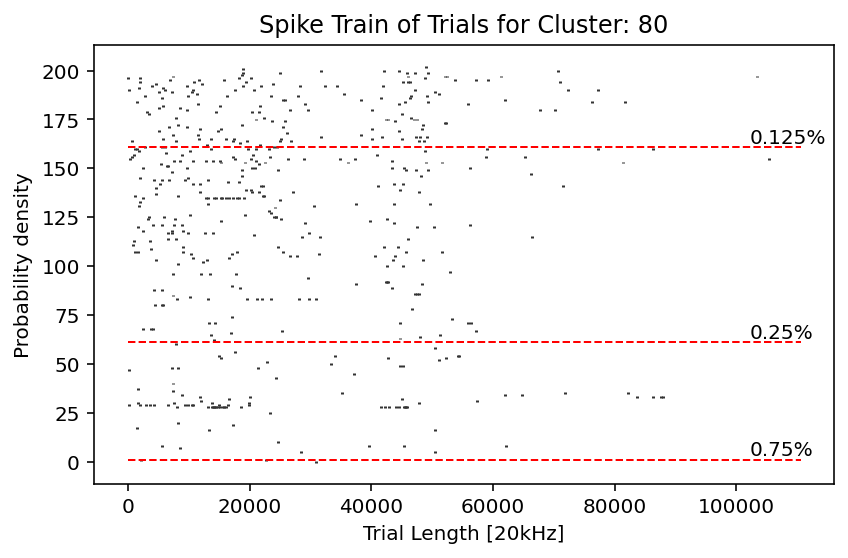

In [367]:
JG14_190621.spikes.plt_spike_train(80)

<IPython.core.display.Javascript object>


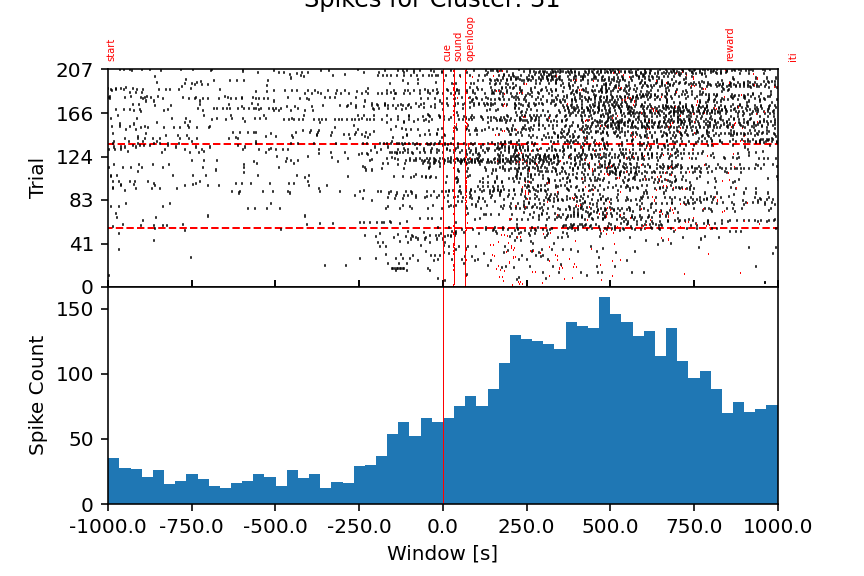

<ipython-input-63-6bf8cc080566>:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)


In [64]:
plt_spike_train_hist_all_events(self, cluster, selected_trials_df, 'cue', window)

<IPython.core.display.Javascript object>


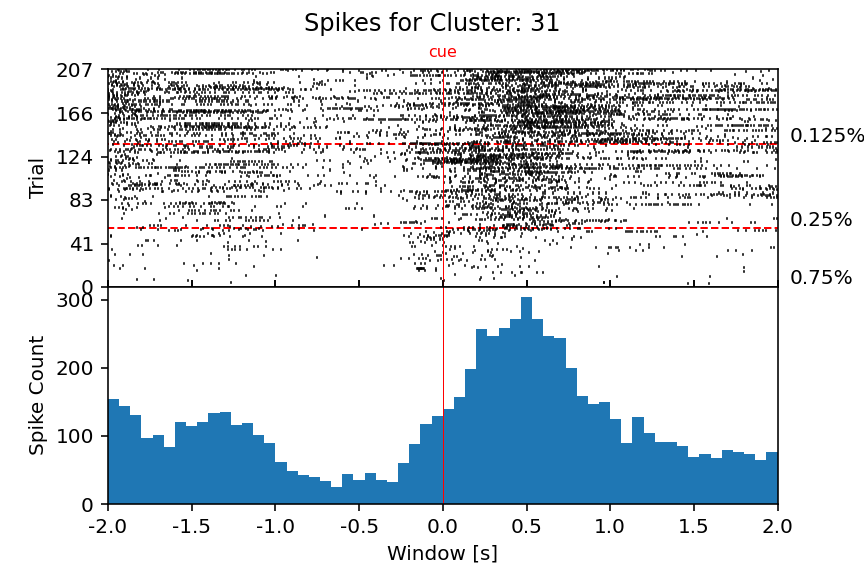

<ipython-input-14-52e05385f583>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)


In [18]:
plt_spike_train_hist(self, cluster, selected_trials_df, event, window)

<IPython.core.display.Javascript object>


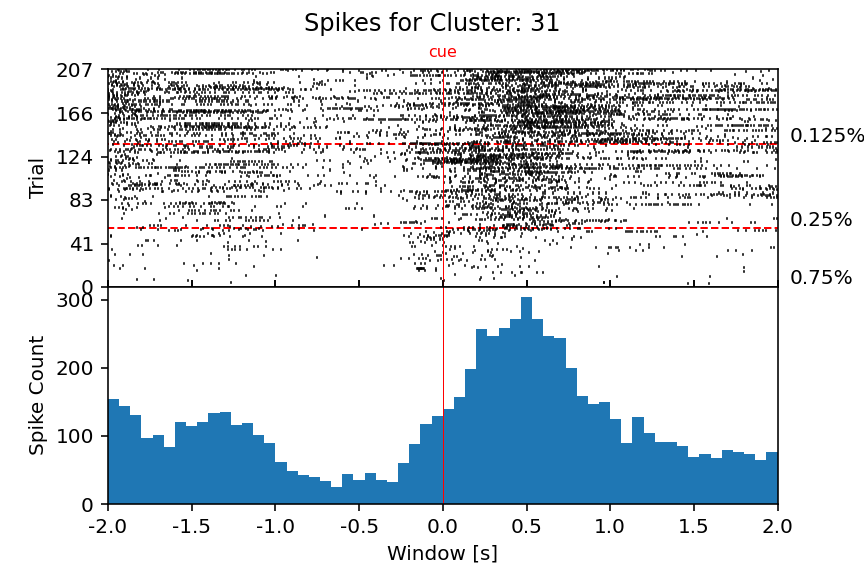

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/spikes_class.py:601: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)


(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'cue'}, ylabel='Trial'>,
        <AxesSubplot:xlabel='Window [s]', ylabel='Spike Count'>],
       dtype=object))

In [20]:


self.plt_spike_train_hist(cluster, selected_trials_df, event, window)


<IPython.core.display.Javascript object>


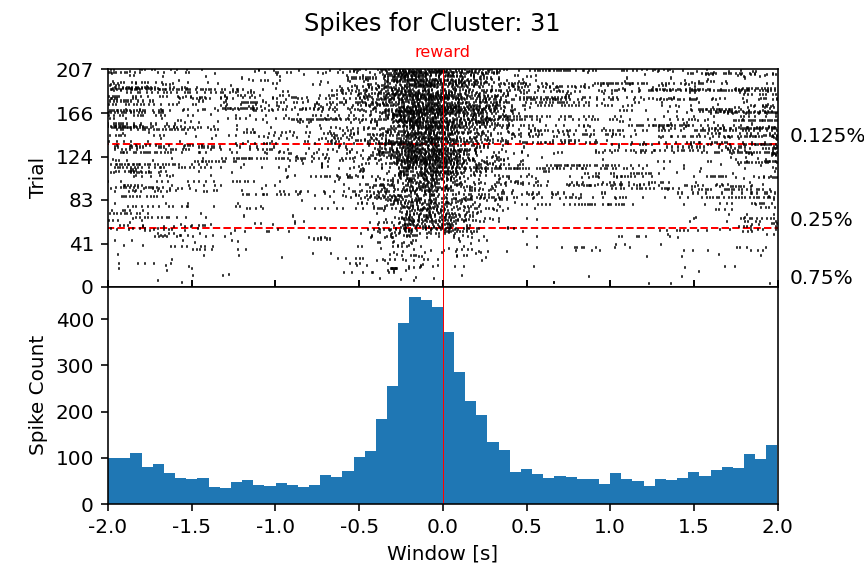

<ipython-input-14-52e05385f583>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(y_index)


In [22]:
plt_spike_train_hist(self, cluster, selected_trials_df, 'reward', window)

# SDA

## Bootstrapping

### WRONG get spikes for random windows for all clusters all trials

In [1461]:
@njit()

# get spike window aligned to random events =======================================================

#def create_random_start(x,z, trials_ar, delta):
#    random_li = np.zeros(shape=(x,z))
#    for i in range(x):
#        random_li[i,:]=(np.random.randint((trials_ar[i,0]+delta),(trials_ar[i,1]-delta), size=(z)) )-trials_ar[i,0]
#    return random_li


def create_random_start(trial_nr,iter_nr, trials_ar, delta):
    """get random event within trial

    Args:
        trial_nr (int): number of trials
        iter_nr (int): number of iterations
        trials_df (numpy ar): dataframe from spikes class with all trials
        delta (float): window = 2*delta

    Returns:
        random_li(numpy ar): array with random start points, (i=trial_nr, j=iter_nr)
    """
    #initialize complete dataframe
    random_li = np.zeros(shape=(trial_nr,iter_nr))
    #iterate over trials
    for i in range(trial_nr):
        random_li[i,:]=(np.random.randint((trials_ar[i,0]+delta),(trials_ar[i,1]-delta), size=(iter_nr)) )-trials_ar[i,0]
    return random_li


def get_spikes_in_window_per_trial(data_ar, i, delta):
    """get all spikes that fall into window(+-delta) around event i 

    Args:
        data_ar (np ar): spike times
        i (float): event time
        delta (float): 1/2 window width in sampling points

    Returns:
        np ar: array with spike times that are in window
    """
    return (data_ar[( (data_ar>=(i-delta)) & (data_ar<=(i+delta)) )]-(i-delta))


def get_spikes_in_window_per_trial_all_randrang(data_ar, range_ar):
    """get all spikes that fall in all random generated windows for specific trial

    Args:
        data_ar (numpy ar): spikes_per_trial_ar[cluster,trial,:] from spikes class
        range_ar (numpy ar): random_li output from create_random_start function

    Returns:
        list: list of arrays with spikes for all iterations for specific trial
    """
    results_li = list()
    #binned_li = list()
    #range_li = list()
    for i in range_ar:
        #range_li.append(((i-delta),(i+delta)))
        #results_li.append(data_ar[( (data_ar>=(i-delta)) & (data_ar<=(i+delta)) )]-(i-delta))
        results_li.append(get_spikes_in_window_per_trial(data_ar, i, delta))
        #binned_li.append( (np.histogram(results_li[-1], bins=50, range=[(i-delta),(i+delta)]))[0] )
    return results_li#, binned_li#, range_li #np.array(results_li,dtype=object)


def get_spikes_in_window_all_trial_all_randrang(spikes_per_trial_df, random_ar):
    """get spikes for all trials and iterations

    Args:
        spikes_per_trial_df (np ar): spikes class matrix from
        random_ar (np ar): random events

    Returns:
        li: list of lists with all spikes for all trials and all iterations
    """ 
    spiketimes_li = list()
    #binnes_li = list()
    for i in range(spikes_per_trial_df.shape[0]):
        #results_li, binned_li = get_random_range_spikes(spikes_per_trial_df[i].values, random_ar[i])
        spiketimes_li.append(get_spikes_in_window_per_trial_all_randrang(spikes_per_trial_df[i].values, random_ar[i]))
        #binnes_li.append(binned_li)
    return spiketimes_li#, binnes_li


def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        for it in range(iterations):
            data_ar[cl,:,it]=(np.histogram(np.concatenate(input_ar[cl,:,it]).ravel(),bins=nr_bins))[0]
    return data_ar


def bin_trial_spike_times_single_cluster(input_ar,nr_bins):
    """binn randm windows from single clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for single clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=bin,j=iteration, data=bin count)
    """
    iterations=input_ar.shape[1]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(nr_bins,iterations),dtype=int)
    for it in range(iterations):
        data_ar[:,it]=(np.histogram(np.concatenate(input_ar[:,it]).ravel(),bins=nr_bins))[0]
    return data_ar



# get spike window aligned to reward event =======================================================

# fixed event
def get_spikes_in_window_all_trials_singlevent(spikes_ar_all, event_ar, delta):
    """get all spikes that fall in window of specific event for all trials

    Args:
        spikes_ar_all (np ar): array of arrays of spike times for each trial
        event_ar (np ar): array of event times for each trial
        delta (float): 1/2 window width in sampling points

    Returns:
        list: list of arrays with all spike times that fall in window for each trial
    """
    spikes_li_all = list()
    for trial in range(event_ar.shape[0]):
        spikes_li_all.append(get_spikes_in_window_per_trial(spikes_ar_all.values, event_ar[trial], delta))
    return spikes_li_all


In [153]:
def plt_surf_single_cluster(binned_ar):
    '''
    ======================
    3D surface + color map 
    ======================
    plot a surface of bin_counts for given binned data arrayo
    ver bins (x=bin, y=iterations, z=bin_count)
    
    binned_ar[numpy ar]: binned data array for random spike windows selected from all trials single cluster
    '''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    import numpy as np

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # get dimension
    # x = bins
    # y = iteration
    # z = spikes in bin
    x,y=binned_ar.shape

    # get data.
    X = np.arange(0,x)
    Y = np.arange(0,y)
    X, Y = np.meshgrid(X, Y)
    # actual data
    Z = binned_ar[:,:].T

    # Plot the surface.
    surf = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    return fig, ax

def plt_test_plot_raw_spikes(spikes_ar, binned_ar, cluster, bins):
    """
    ======================
    histogram comparison
    ======================
    comparison of histograms generated from already binned data 
    and raw spikes for all trials all iterations
    for testing purposis
    
    spikes_ar[numpy array]: raw spikes for all clusters, trials, and iterations 
        (i=cluster,j=trial,k=iteration,data=np.arry with spike times)
    binned_ar[numpy array]: already binned data
        (i=cluster, j=bins, k=iterations, data=count of spikes per bin)
    """
    # create suplots left and right 
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'wspace': 0})
    # iterate over some of the random iterations
    for i in [0,1,5,10,100,500]:
        # create histogram from raw spikes left
        ax[0].hist(np.concatenate(spikes_ar[cluster,:,i]).ravel(),bins=bins)
        # create bar plot from already binned data
        ax[1].bar(np.arange(0,bins),binned[cluster,:,i],width=1.0,label=f"itr:{i}")
    [fixed_aspect_ratio(0.8,a) for a in ax]
    #fixed_aspect_ratio(0.8,ax[0])
    #fixed_aspect_ratio(0.8,ax[1])
    # create comon legend
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels,loc=8,ncol=6)
    return fig, ax

def fixed_aspect_ratio(ratio,ax):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = ax.get_xlim(),ax.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    ax.set_aspect(ratio*(xrange/yrange), adjustable='box')
    
    

def plt_compare_random_fixed(cluster,delta,bins,reward_aligned_ar,mean_ar,percentil_ar):
    
    x=np.linspace(-delta,+delta,bins)
    
    fig,ax = plt.subplots()

    binned_reward = np.histogram(np.concatenate(reward_aligned_ar[cluster]).ravel(), bins=bins)[0]
    ax.plot(x,binned_reward, linewidth=3, alpha=1, label="reward aligned ")

    # 
    ax.axvline(x=0,linewidth=1, color='r', label="reward")
    ax.plot(x,mean_ar[cluster], color="black", label="mean")

    # plot +-95%
    #ax.fill_between(x, np.zeros(bins), percentil_ar[4,:], color='b', alpha=.3, label="0.5th% to 99.5th%")
    ax.fill_between(x, percentil_ar[0,cluster,:], percentil_ar[4,cluster,:], color='b', alpha=0.3, label="0.5th% to 99.5th%")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels,loc=1,ncol=6)
    
    return fig,ax

    


In [ ]:
# -> in class

In [ ]:
def get_bootstrap_all_clusters(self, window, iterations,bins):
    """generate data array with random selected events and spike counts for each window around event

    Args:
        window (int): 1/2 window widt in milli seconds
        iterations (int): number of random iterations
    Returns:
        np ar: array with spike counts for i=clusters, j=trials, k=iterations, data = spike times
    """
    delta = window*20
    
    # initialize data array 
    #y=clusters
    y=self.spikes_per_trial_ar.shape[0]
    #x=trials
    x=self.spikes_per_trial_ar.shape[1]
    #z=random_events 
    z=iterations


    # create zeros data array dtype object
    spiketimes_data_ar = np.zeros(shape=(y,x,z),dtype=object)
    
    # reward alignded database
    reward_aligned_ar = np.zeros(y,dtype=object)
    
    #### create random start point array for all trials 
    #get trial data
    trial_ar = np.zeros((x,2))
    trial_ar[:,0]=self.selected_trials_df['start']
    trial_ar[:,1]=self.selected_trials_df['end']
    #
    random_ar = np.zeros(shape=(x,z),dtype=int)
    random_ar = create_random_start(x,z, trial_ar, delta)

    #get spikes for all clusters
    for i in range(y):
        spiketimes_data_ar[i,:,:] =get_spikes_in_window_all_trial_all_randrang(self.spikes_per_trial_ar[i], random_ar)

        cluster_name = self.get_cluster_name_from_neuron_idx(i)
        spikes = self.spikes_df[self.spikes_df.loc[:]['cluster'] == cluster_name]['spike_times']
        trials = self.selected_trials_df['reward']
        reward_aligned_ar[i]=get_spikes_in_window_all_trials_singlevent(spikes,trials,delta)


    #create flattend spike times for each iteration
    binned = bin_trial_spike_times_all_cluster(spiketimes_data_ar,bins)

    # calulate mean array
    mean_ar = np.mean(binned, axis=2)
    #mean_cl = np.mean(mean_ar, axis=1)
    percentil_ar=np.percentile(binned, [0.5,25,50,75,99.5], axis=2)
    
    return spiketimes_data_ar, reward_aligned_ar, binned, mean_ar, percentil_ar



def get_bootstrap_single_cluster(self, window, iterations, cluster):


In [ ]:
session = JG18b_190828

window = 800
iterations = 1000
bins = 50

spiketimes_data_ar, reward_aligned_ar, binned, mean_ar, percentil_ar = get_randomized_windows_all_clusters(session.sda, window, iterations,bins)



In [1300]:
##### Generate Stat Ana Data ###########

In [1462]:
%%time

session = JG18b_190828

cluster = 48
cluster_name = session.sda.get_cluster_name_from_neuron_idx(cluster)

window = 800
iterations = 1000
bins = 50
delta = window*20

# initialize data array ===========================================
#y=clusters
y=session.sda.spikes_per_trial_ar.shape[0]
#x=trials
x=session.sda.spikes_per_trial_ar.shape[1]
#z=random_events 
z=iterations

# create zeros data array dtype object
spiketimes_data_ar = np.zeros(shape=(y,x,z),dtype=object)
#spike_times_all_trials_ar =
#binned_data_ar = np.zeros(shape=(y,x,z),dtype=object)

# reward alignded database
reward_aligned_ar = np.zeros(y,dtype=object)


#### create random start point array for all trials ===============
# random ar
#get trial data
trial_ar = np.zeros((x,2))
trial_ar[:,0]=session.sda.selected_trials_df['start']
trial_ar[:,1]=session.sda.selected_trials_df['end']
#
random_ar = np.zeros(shape=(x,z),dtype=int)
random_ar = create_random_start(x,z, trial_ar, delta)

#get spikes for all clusters
for i in range(y):
    spiketimes_data_ar[i,:,:] =get_spikes_in_window_all_trial_all_randrang(session.sda.spikes_per_trial_ar[i], random_ar)
    
    cluster_name = session.sda.get_cluster_name_from_neuron_idx(i)
    spikes = session.sda.spikes_df[session.sda.spikes_df.loc[:]['cluster'] == cluster_name]['spike_times']
    trials = session.sda.selected_trials_df['reward']
    reward_aligned_ar[i]=get_spikes_in_window_all_trials_singlevent(spikes,trials,delta)
    

#create flattend spike times for each iteration
binned = bin_trial_spike_times_all_cluster(spiketimes_data_ar,bins)

# calulate mean array
mean_ar = np.mean(binned, axis=2)
mean_cl = np.mean(mean_ar, axis=1)
percentil_ar=np.percentile(binned, [0.5,25,50,75,99.5], axis=2)



# only for single cluster
#spiketimes_data_ar = np.zeros(shape=(x,z),dtype=object)
#spiketimes_data_ar[:,:] =get_random_range_spikes_all_trials(session.sda.spikes_per_trial_ar[cluster], random_ar)
#create flattend spike times for each iteration
#binned = bin_trial_spike_times_single_cluster(spiketimes_data_ar,bins)

# calulate mean array
#mean_ar = np.mean(binned, axis=1)
#mean_cl = np.mean(mean_ar, axis=0)
#percentil_ar=np.percentile(binned, [0.5,25,50,75,99.5], axis=1)


#spikes = JG18b_190828.sda.spikes_df[JG18b_190828.spikes.spikes_df.loc[:]['cluster'] == cluster_name]['spike_times']
#trials = selected_trials['reward']
#reward_aligned = get_spikes_in_window_all_trials_singlevent(spikes,trials,delta)

CPU times: user 5min 3s, sys: 1.59 s, total: 5min 5s
Wall time: 5min 6s


In [8]:
session = JG18b_190828

window = 800
iterations = 1000
bins = 50

spiketimes_data_ar, reward_aligned_ar, binned, mean_ar, percentil_ar = session.sda.get_bootstrap_all_clusters(window, iterations,bins)



In [10]:
session.sda.plt_surf_single_cluster(binned[48])

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 2 Axes>, <Axes3DSubplot:>)

In [16]:
session.sda.plt_compare_random_fixed(48,window,bins,reward_aligned_ar,mean_ar,percentil_ar)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [11]:
session.sda.plt_test_plot_raw_spikes(spiketimes_data_ar, binned, 48, bins)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

### NEW Bootstrap

In [120]:
@njit(parallel=True)

def create_random_start(trial_nr,iter_nr, trials_ar, delta):
    """get random event within trial

    Args:
        trial_nr (int): number of trials
        iter_nr (int): number of iterations
        trials_df (numpy ar): dataframe from spikes class with all trials
        delta (float): window = 2*delta

    Returns:
        random_li(numpy ar): array with random start points, (i=trial_nr, j=iter_nr)
    """
    #initialize complete dataframe
    random_li = np.zeros(shape=(trial_nr,iter_nr))
    #iterate over trials
    for i in range(trial_nr):
        random_li[i,:]=(np.random.randint((trials_ar[i,0]),(trials_ar[i,1]), size=(iter_nr)) )
    return random_li

def get_spikes_in_window(data_ar, i, delta):
    """get all spikes that fall into window(+-delta) around event i 

    Args:
        data_ar (np ar): spike times
        i (float): event time
        delta (float): 1/2 window width in sampling points

    Returns:
        np ar: array with spike times that are in window
    """
    #data_ar = (data_ar[( (data_ar>=(i-delta)) & (data_ar<=(i+delta)) )])-(i)
    #if data_ar.shape[0]==0:
    #    return 0
    #else:
    #    return data_ar
    return (data_ar[( (data_ar>=(i-delta)) & (data_ar<=(i+delta)) )])-(i)

def get_spikes_in_window_per_trial_all_randrang(data_ar, range_ar, delta):
    """get all spikes that fall in all random generated windows for specific trial

    Args:
        data_ar (numpy ar): spikes_per_trial_ar[cluster,trial,:] from spikes class
        range_ar (numpy ar): random_li output from create_random_start function

    Returns:
        list: list of arrays with spikes for all iterations for specific trial
    """
    results_li = list()
    # iterate ove all 1000 random events
    for i in range_ar:
        results_li.append(get_spikes_in_window(data_ar, i, delta))
    return results_li

def get_spikes_in_window_all_trial_all_randrang(spikes_ar, random_ar, delta, trials_ar):
    """get spikes for all trials and iterations

    Args:
        spikes_per_trial_df (np ar): spikes class matrix from
        random_ar (np ar): random events

    Returns:
        li: list of lists with all spikes for all trials and all iterations
    """ 
    spiketimes_li = list()
    #iteate over trials
    for tr in range(random_ar.shape[0]):
        # subselect for delta+start ---- delta+end spiketimes to speed up
        data_ar = spikes_ar[ (spikes_ar>=trials_ar[0,0]-delta) & (spikes_ar<=trials_ar[0,1]+delta) ]
        #get spike times around all random windows
        spiketimes_li.append(get_spikes_in_window_per_trial_all_randrang(data_ar, random_ar[tr], delta))
    return spiketimes_li




# fixed event
def get_spikes_in_window_all_trials_singlevent(spikes_ar, event_ar, delta):
    """get all spikes that fall in window of specific event for all trials

    Args:
        spikes_ar_all (np ar): array of arrays of spike times for each trial
        event_ar (np ar): array of event times for each trial
        delta (float): 1/2 window width in sampling points

    Returns:
        list: list of arrays with all spike times that fall in window for each trial
    """
    spikes_li_all = list()
    for trial_event in event_ar:
        spikes_li_all.append(get_spikes_in_window(spikes_ar, trial_event, delta))
    return spikes_li_all


# binn data
def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        data_ar[cl,:,:]=bin_trial_spike_times_single_cluster(input_ar[cl,:,:],nr_bins)
    return data_ar

def bin_trial_spike_times_single_cluster(input_ar,nr_bins):
    """binn randm windows from single clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for single clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=bin,j=iteration, data=bin count)
    """
    iterations=input_ar.shape[1]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(nr_bins,iterations),dtype=int)
    for it in range(iterations):
        # check if array not empty
        data_ar[:,it]=(np.histogram(np.concatenate(input_ar[:,it]).ravel(),bins=nr_bins))[0]
    return data_ar

In [ ]:
%%time

window = 2000
iterations = 1000
bins = 50
delta = window*20
event='reward'

cluster=48
session= JG18b_190828


# initialize data array ===========================================
#y=clusters
y=session.sda.spikes_per_cluster_ar.shape[0]
#x=trials
x=session.sda.selected_trials_df.shape[0]
#z=random_events 
z=iterations

# initialize array
spiketimes_data_ar = np.zeros(shape=(y,x,z),dtype=object)
# reward alignded database
reward_aligned_ar = np.zeros(y,dtype=object)



# prepare trial times
trials_ar = np.zeros((x,3))
trials_ar[:,0]=session.sda.selected_trials_df['start']
trials_ar[:,1]=session.sda.selected_trials_df['end']
trials_ar[:,2]=session.sda.selected_trials_df[event]

random_ar = np.zeros(shape=(x,z),dtype=int)
random_ar = create_random_start(x,z, trials_ar, delta)

# get spikes
for cl in range(y):
    spiketimes_data_ar[cl,:,:] = get_spikes_in_window_all_trial_all_randrang(session.sda.spikes_per_cluster_ar[cl], random_ar, delta, trials_ar)
    reward_aligned_ar[cl]=get_spikes_in_window_all_trials_singlevent(session.sda.spikes_per_cluster_ar[cl], trials_ar[:,2], delta)

#
#spiketimes_data_ar[cluster,:,:] = get_spikes_in_window_all_trial_all_randrang(session.sda.spikes_per_cluster_ar[cluster], random_ar, delta)
#reward_aligned_ar[cluster]=get_spikes_in_window_all_trials_singlevent(session.sda.spikes_per_cluster_ar[cluster], trials_ar[:,2], delta)


#create flattend spike times for each iteration
binned = bin_trial_spike_times_all_cluster(spiketimes_data_ar,bins)

# calulate mean array
mean_ar = np.mean(binned, axis=2)
mean_cl = np.mean(mean_ar, axis=1)
percentil_ar=np.percentile(binned, [0.5,25,50,75,99.5], axis=2)




In [ ]:
# parallel true = 4.08
# parallel + fastmath = 5.24
# fastmath = 4.28
# none = 4.42

### Analyze

In [6]:
session = JG14_190621

window = 2000
iterations = 1000
bins = 50

#spiketimes_data_ar, reward_aligned_ar, binned, mean_ar, percentil_ar = session.sda.get_bootstrap_all_clusters(window, iterations, bins, 'reward')
spiketimes_data_ar =  session.sda.spiketimes_data_ar.copy()
reward_aligned_ar = session.sda.reward_aligned_ar.copy()
binned  = session.sda.binned.copy()
mean_ar = session.sda.mean_ar.copy()
percentil_ar = session.sda.percentil_ar.copy()


<IPython.core.display.Javascript object>


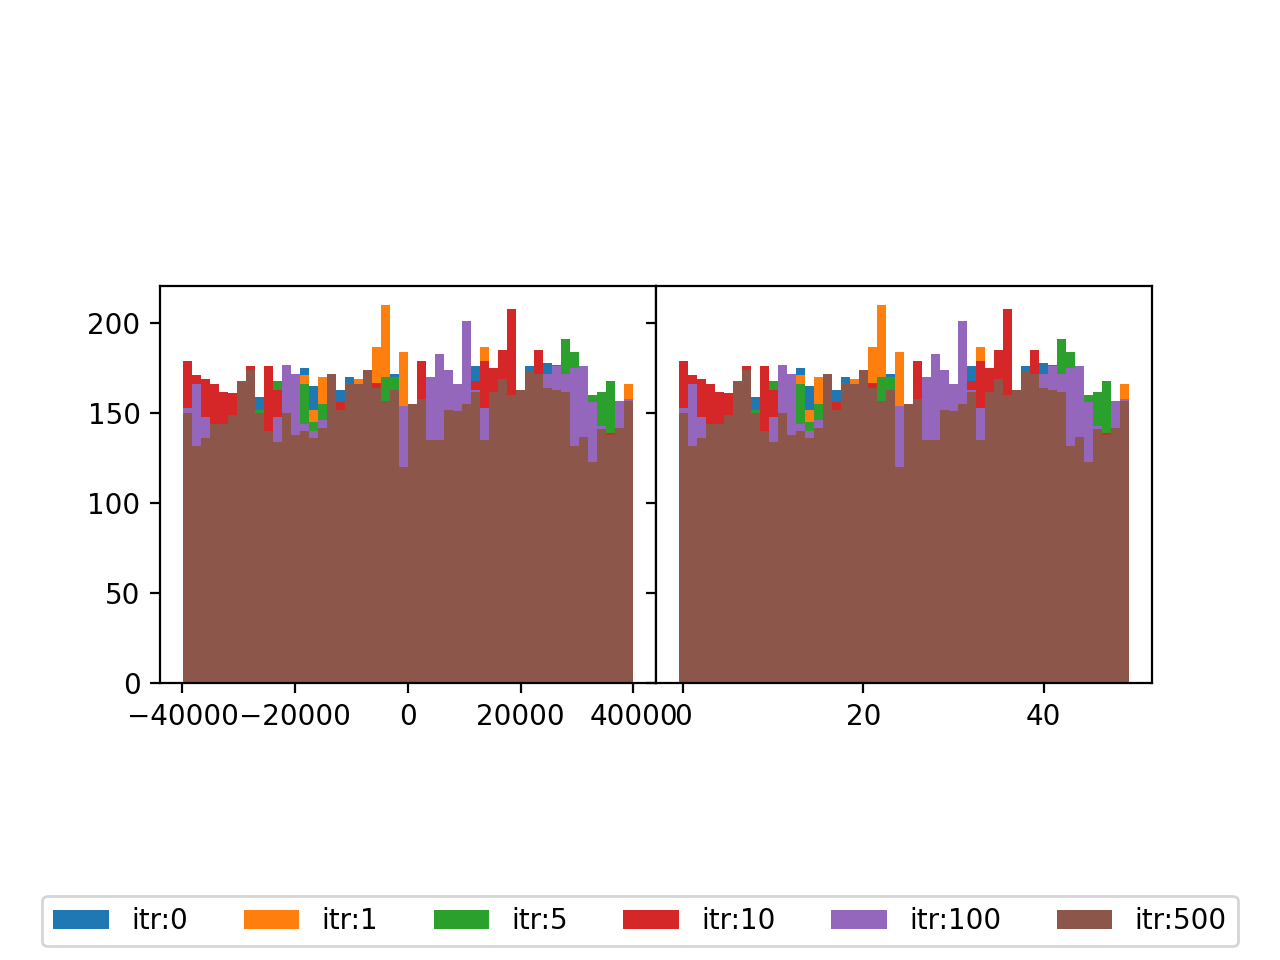

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [21]:
session.sda.plt_test_plot_raw_spikes(spiketimes_data_ar, binned, cluster, bins)

<IPython.core.display.Javascript object>


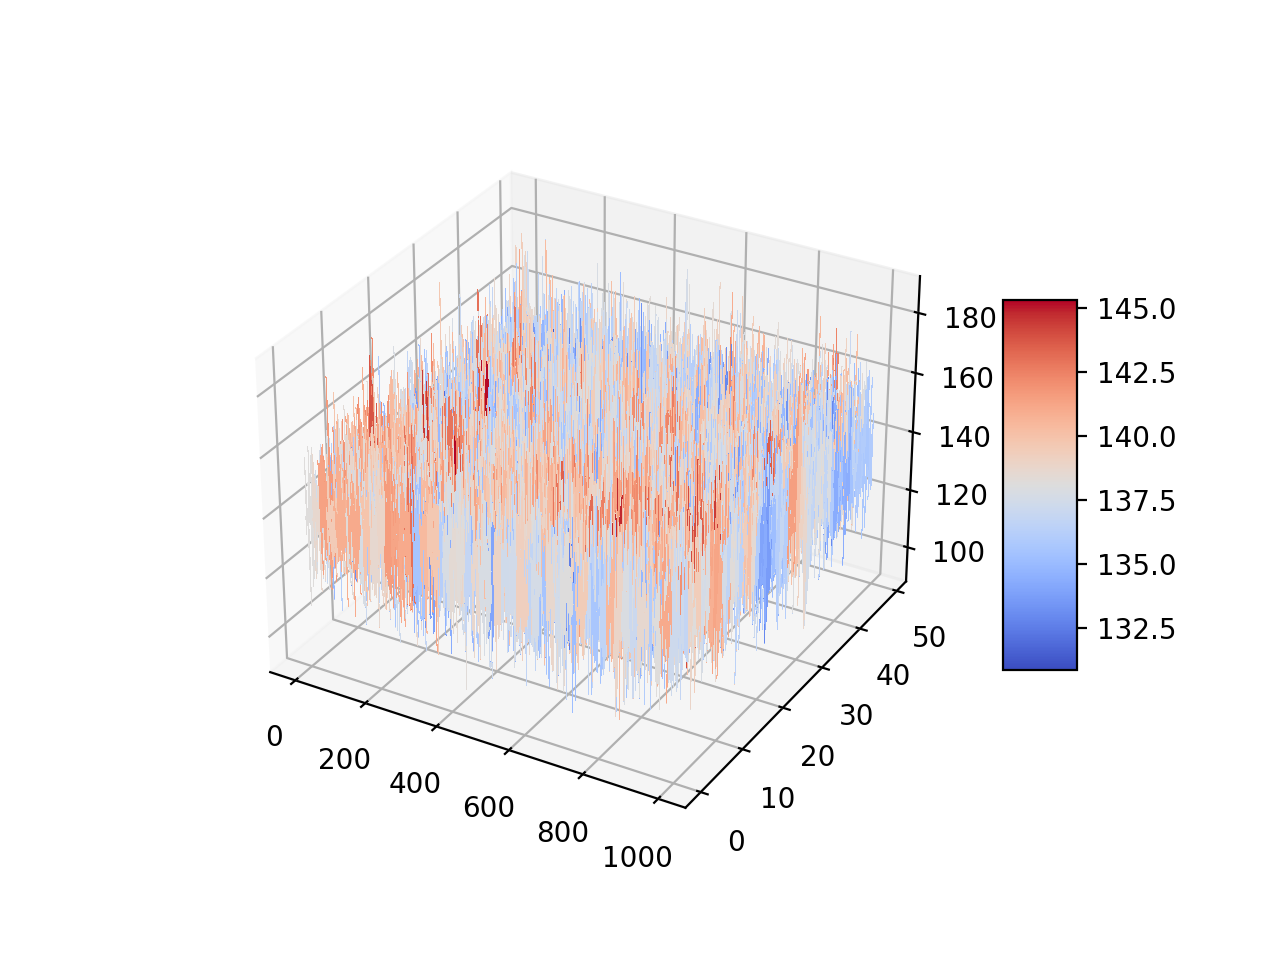

(<Figure size 640x480 with 2 Axes>, <Axes3DSubplot:>)

In [118]:
session.sda.plt_surf_single_cluster(binned[cluster])

<IPython.core.display.Javascript object>


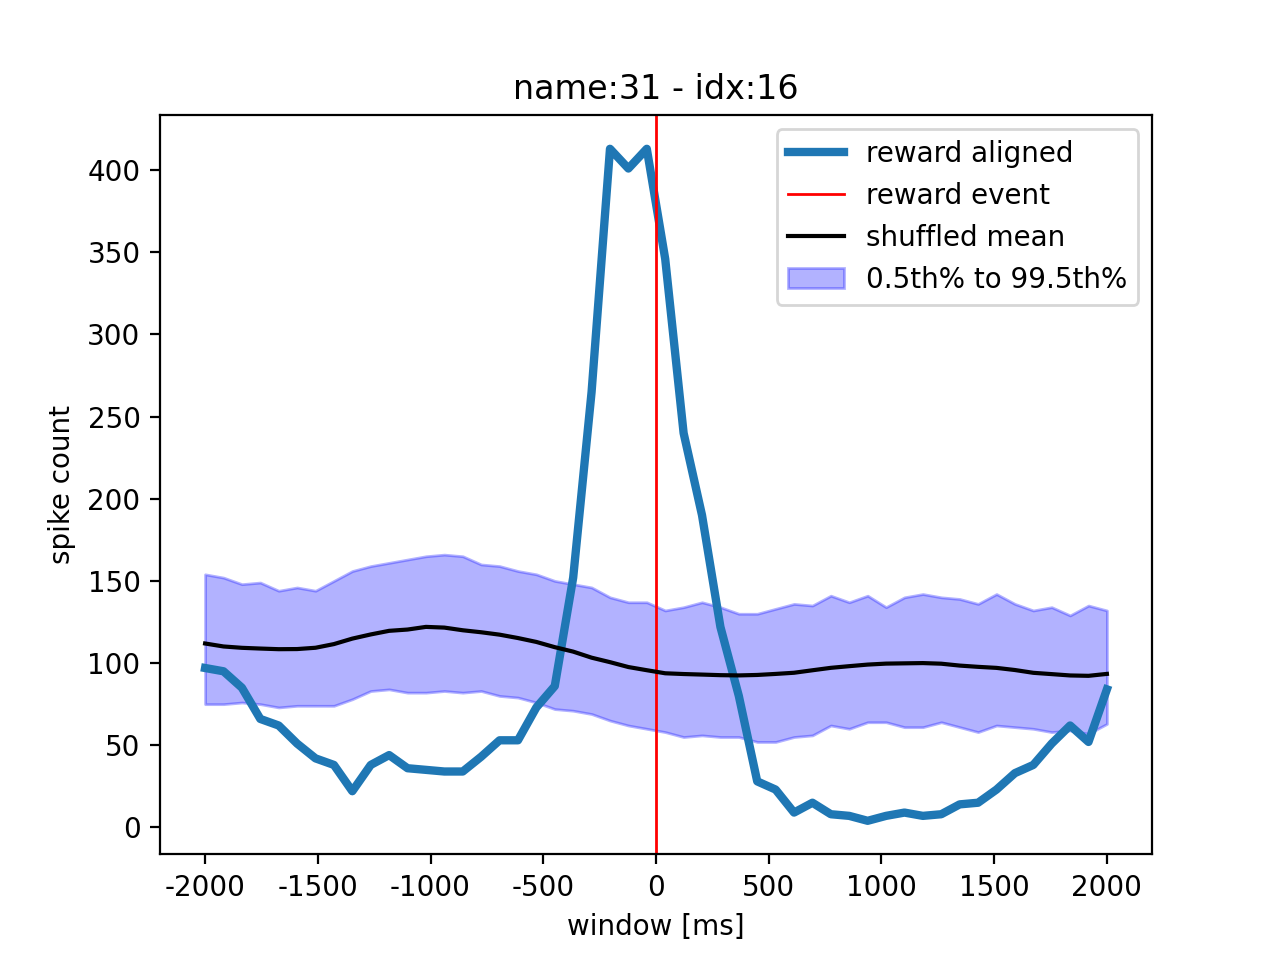

/Users/max/Google Drive/3.1 Code Repository/3 Masterarbeit/Spikes/sda_class.py:380: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'name:31 - idx:16'}, xlabel='window [ms]', ylabel='spike count'>)

In [132]:
session.sda.plt_compare_random_fixed(16,window,bins,reward_alinged_subselected_reward_ar,mean_subselected_reward_ar,percentil_subselected_reward_ar)

In [30]:
%%time
# cluster and neuron index
all_cluster_names = session.sda.clusters_df[session.sda.clusters_df['group']=='good'].index.values
all_cluster_ids = np.arange(session.sda.spikes_per_cluster_ar.shape[0])


# selecte rewarded trials
trial_selector_reward = session.sda.selected_trials_df['reward_given'].values
trial_selector_no_reward = np.invert(session.sda.selected_trials_df['reward_given'].values)
trial_selector_gamble = session.sda.selected_trials_df[session.sda.gamble_side].values
trial_selector_save = np.invert(session.sda.selected_trials_df[session.sda.gamble_side].values)


# block selector
blocks = session.sda.selected_trials_df['probability'].unique()

trial_selector_block1 = session.sda.selected_trials_df['probability']==blocks[0]
trial_selector_block2 = session.sda.selected_trials_df['probability']==blocks[1]
trial_selector_block3 = session.sda.selected_trials_df['probability']==blocks[2]

# Subselected Trials =============================================
# reward algined subselected reward
reward_alinged_subselected_reward = reward_aligned_ar[:,trial_selector_reward]
spiketimes_data_subselected_reward = spiketimes_data_ar[:,trial_selector_reward,:]
binned_subselected_reward = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_reward,50)
mean_subselected_reward = np.mean(binned_subselected_reward, axis=2)
percentil_subselected_reward = np.percentile(binned_subselected_reward, [0.5,25,50,75,99.5], axis=2)

# reward aligned subselected no reward
reward_alinged_subselected_no_reward = reward_aligned_ar[:,trial_selector_no_reward]
spiketimes_data_subselected_no_reward = spiketimes_data_ar[:,trial_selector_no_reward,:]
binned_subselected_no_reward = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_no_reward,50)
mean_subselected_no_reward = np.mean(binned_subselected_no_reward, axis=2)
percentil_subselected_no_reward = np.percentile(binned_subselected_no_reward, [0.5,25,50,75,99.5], axis=2)

# reward aligned subselected gamble
reward_alinged_subselected_gamble = reward_aligned_ar[:,trial_selector_gamble]
spiketimes_data_subselected_gamble = spiketimes_data_ar[:,trial_selector_gamble,:]
binned_subselected_gamble = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_gamble,50)
mean_subselected_gamble = np.mean(binned_subselected_gamble, axis=2)
percentil_subselected_gamble = np.percentile(binned_subselected_gamble, [0.5,25,50,75,99.5], axis=2)


# reward aligned subselected safe
reward_alinged_subselected_save = reward_aligned_ar[:,trial_selector_save]
spiketimes_data_subselected_save = spiketimes_data_ar[:,trial_selector_save,:]
binned_subselected_save = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_save,50)
mean_subselected_save = np.mean(binned_subselected_save, axis=2)
percentil_subselected_save = np.percentile(binned_subselected_save, [0.5,25,50,75,99.5], axis=2)


# Binned Trials ================================================
# Bin 1 reward
reward_alinged_subselected_block1_rw = reward_aligned_ar[:,( (trial_selector_block1)&(trial_selector_reward) )]
spiketimes_data_subselected_block1_rw = spiketimes_data_ar[:,( (trial_selector_block1)&(trial_selector_reward) ),:]
binned_subselected_block1_rw = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_block1_rw,50)
mean_subselected_block1_rw = np.mean(binned_subselected_block1_rw, axis=2)
percentil_subselected_block1_rw = np.percentile(binned_subselected_block1_rw, [0.5,25,50,75,99.5], axis=2)

# Bin 1 no-reward
reward_alinged_subselected_block1_norw = reward_aligned_ar[:,( (trial_selector_block1)&(trial_selector_no_reward) )]
spiketimes_data_subselected_block1_norw = spiketimes_data_ar[:,( (trial_selector_block1)&(trial_selector_no_reward) ),:]
binned_subselected_block1_norw = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_block1_norw,50)
mean_subselected_block1_norw = np.mean(binned_subselected_block1_norw, axis=2)
percentil_subselected_block1_norw = np.percentile(binned_subselected_block1_norw, [0.5,25,50,75,99.5], axis=2)

##
# Bin 2 reward
reward_alinged_subselected_block2_rw = reward_aligned_ar[:,( (trial_selector_block2)&(trial_selector_reward) )]
spiketimes_data_subselected_block2_rw = spiketimes_data_ar[:,( (trial_selector_block2)&(trial_selector_reward) ),:]
binned_subselected_block2_rw = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_block2_rw,50)
mean_subselected_block2_rw = np.mean(binned_subselected_block2_rw, axis=2)
percentil_subselected_block2_rw = np.percentile(binned_subselected_block2_rw, [0.5,25,50,75,99.5], axis=2)

# Bin 2 no-reward
reward_alinged_subselected_block2_norw = reward_aligned_ar[:,( (trial_selector_block2)&(trial_selector_no_reward) )]
spiketimes_data_subselected_block2_norw = spiketimes_data_ar[:,( (trial_selector_block2)&(trial_selector_no_reward) ),:]
binned_subselected_block2_norw = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_block2_norw,50)
mean_subselected_block2_norw = np.mean(binned_subselected_block2_norw, axis=2)
percentil_subselected_block2_norw = np.percentile(binned_subselected_block2_norw, [0.5,25,50,75,99.5], axis=2)

##
# Bin 3 reward
reward_alinged_subselected_block3_rw = reward_aligned_ar[:,( (trial_selector_block3)&(trial_selector_reward) )]
spiketimes_data_subselected_block3_rw = spiketimes_data_ar[:,( (trial_selector_block3)&(trial_selector_reward) ),:]
binned_subselected_block3_rw = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_block3_rw,50)
mean_subselected_block3_rw = np.mean(binned_subselected_block3_rw, axis=2)
percentil_subselected_block3_rw = np.percentile(binned_subselected_block3_rw, [0.5,25,50,75,99.5], axis=2)

# Bin 3 no-reward
reward_alinged_subselected_block3_norw = reward_aligned_ar[:,( (trial_selector_block3)&(trial_selector_no_reward) )]
spiketimes_data_subselected_block3_norw = spiketimes_data_ar[:,( (trial_selector_block3)&(trial_selector_no_reward) ),:]
binned_subselected_block3_norw = bin_trial_spike_times_all_cluster(spiketimes_data_subselected_block3_norw,50)
mean_subselected_block3_norw = np.mean(binned_subselected_block3_norw, axis=2)
percentil_subselected_block3_norw = np.percentile(binned_subselected_block3_norw, [0.5,25,50,75,99.5], axis=2)


CPU times: user 2min 15s, sys: 777 ms, total: 2min 16s
Wall time: 2min 19s


In [ ]:
%%time
# save all figs

# rewaqrd, no-reward
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_reward,
                                                    mean_subselected_reward,
                                                    percentil_subselected_reward,
                                                    "reward_aligned_reward"
                                                    )
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_no_reward,
                                                    mean_subselected_no_reward,
                                                    percentil_subselected_no_reward,
                                                    "reward_aligned_no_reward"
                                                    )

# gamble no gamble
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_gamble,
                                                    mean_subselected_gamble,
                                                    percentil_subselected_gamble,
                                                    "reward_aligned_gamble"
                                                    )
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_save,
                                                    mean_subselected_save,
                                                    percentil_subselected_save,
                                                    "reward_aligned_safe")

# block 1 reward, no-reward
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_block1_rw,
                                                    mean_subselected_block1_rw,
                                                    percentil_subselected_block1_rw,
                                                    "reward_aligned_reward_block1"
                                                    )
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_block2_rw,
                                                    mean_subselected_block2_rw,
                                                    percentil_subselected_block2_rw,
                                                    "reward_aligned_no_reward_block1"
                                                    )
untitled:Untitled-1
# block 2 reward, no-reward
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_block2_rw,
                                                    mean_subselected_block2_rw,
                                                    percentil_subselected_block2_rw,
                                                    "reward_aligned_reward_block2"
                                                    )
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_block2_norw,
                                                    mean_subselected_block2_norw,
                                                    percentil_subselected_block2_norw,
                                                    "reward_aligned_no_reward_block2"
                                                    )

# block 3 reward, no-reward
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_block3_rw,
                                                    mean_subselected_block3_rw,
                                                    percentil_subselected_block3_rw,
                                                    "reward_aligned_reward_block3"
                                                    )
session.sda.save_all_clusters_compare_random_fixed(window,
                                                    bins,
                                                    reward_alinged_subselected_block2_norw,
                                                    mean_subselected_block2_norw,
                                                    percentil_subselected_block2_norw,
                                                    "reward_aligned_no_reward_block3"
                                                    )


# Workbench

In [40]:
block2_norw_dict={
        "reward_alinged":11,
        "spiketimes_data":22,
        "binned":33,
        "mean":44,
        "percentiles":55,
        "filename":"reward_aligned_block2_no_reward"
        }

block3_rw_dict={
        "reward_alinged":1,
        "spiketimes_data":2,
        "binned":3,
        "mean":4,
        "percentiles":5,
        "filename":"reward_aligned_block3_reward"
        }

data_dict = {
            "block2_norw":block2_norw_dict,
            "block3_rw":block3_rw_dict,
            }

[autoreload of sda_class failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/envs/spikes/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/ma

In [37]:
for key,value in data_dict.items():
    value[]

In [38]:
key

'block3_rw'

In [39]:
value

{'reward_alinged': 1,
 'spiketimes_data': 2,
 'binned': 3,
 'mean': 4,
 'percentiles': 5,
 'filename': 'reward_aligned_block3_reward'}

In [248]:
@njit(parallel=True)

def create_random_start(trial_nr,iter_nr, trials_ar, delta):
    """get random event within trial

    Args:
        trial_nr (int): number of trials
        iter_nr (int): number of iterations
        trials_df (numpy ar): dataframe from spikes class with all trials
        delta (float): window = 2*delta

    Returns:
        random_li(numpy ar): array with random start points, (i=trial_nr, j=iter_nr)
    """
    #initialize complete dataframe
    random_li = np.zeros(shape=(trial_nr,iter_nr))
    #iterate over trials
    for i in range(trial_nr):
        random_li[i,:]=(np.random.randint((trials_ar[i,0]),(trials_ar[i,1]), size=(iter_nr)) )
    return random_li

def get_spikes_in_window(data_ar, i, delta):
    """get all spikes that fall into window(+-delta) around event i 

    Args:
        data_ar (np ar): spike times
        i (float): event time
        delta (float): 1/2 window width in sampling points

    Returns:
        np ar: array with spike times that are in window
    """
    #data_ar = (data_ar[( (data_ar>=(i-delta)) & (data_ar<=(i+delta)) )])-(i)
    #if data_ar.shape[0]==0:
    #    return 0
    #else:
    #    return data_ar
    return (data_ar[( (data_ar>=(i-delta)) & (data_ar<=(i+delta)) )])-(i)

def get_spikes_in_window_per_trial_all_randrang(data_ar, range_ar, delta):
    """get all spikes that fall in all random generated windows for specific trial

    Args:
        data_ar (numpy ar): spikes_per_trial_ar[cluster,trial,:] from spikes class
        range_ar (numpy ar): random_li output from create_random_start function

    Returns:
        list: list of arrays with spikes for all iterations for specific trial
    """
    results_li = list()
    # iterate ove all 1000 random events
    for i in range_ar:
        results_li.append(get_spikes_in_window(data_ar, i, delta))
    return results_li

def get_spikes_in_window_all_trial_all_randrang(spikes_ar, random_ar, delta, trials_ar):
    """get spikes for all trials and iterations

    Args:
        spikes_per_trial_df (np ar): spikes class matrix from
        random_ar (np ar): random events

    Returns:
        li: list of lists with all spikes for all trials and all iterations
    """ 
    spiketimes_li = list()
    #iteate over trials
    for tr in range(random_ar.shape[0]):
        # subselect for delta+start ---- delta+end spiketimes to speed up
        data_ar = spikes_ar[ (spikes_ar>=trials_ar[0,0]-delta) & (spikes_ar<=trials_ar[0,1]+delta) ]
        #get spike times around all random windows
        spiketimes_li.append(get_spikes_in_window_per_trial_all_randrang(data_ar, random_ar[tr], delta))
    return spiketimes_li




# fixed event
def get_spikes_in_window_all_trials_singlevent(spikes_ar, event_ar, delta):
    """get all spikes that fall in window of specific event for all trials

    Args:
        spikes_ar_all (np ar): array of arrays of spike times for each trial
        event_ar (np ar): array of event times for each trial
        delta (float): 1/2 window width in sampling points

    Returns:
        list: list of arrays with all spike times that fall in window for each trial
    """
    spikes_li_all = list()
    for trial_event in event_ar:
        spikes_li_all.append(get_spikes_in_window(spikes_ar, trial_event, delta))
    return spikes_li_all


# binn data
def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        data_ar[cl,:,:]=bin_trial_spike_times_single_cluster(input_ar[cl,:,:],nr_bins)
    return data_ar

def bin_trial_spike_times_single_cluster(input_ar,nr_bins):
    """binn randm windows from single clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for single clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=bin,j=iteration, data=bin count)
    """
    iterations=input_ar.shape[1]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(nr_bins,iterations),dtype=int)
    for it in range(iterations):
        # check if array not empty
        data_ar[:,it]=(np.histogram(np.concatenate(input_ar[:,it]).ravel(),bins=nr_bins))[0]
    return data_ar

In [249]:
%%time

window = 2000
iterations = 1000
bins = 50
delta = window*20
event='reward'

cluster=48
session= JG18b_190828


# initialize data array ===========================================
#y=clusters
y=session.sda.spikes_per_cluster_ar.shape[0]
#x=trials
x=session.sda.selected_trials_df.shape[0]
#z=random_events 
z=iterations

# initialize array
spiketimes_data_ar = np.zeros(shape=(y,x,z),dtype=object)
# reward alignded database
reward_aligned_ar = np.zeros(y,dtype=object)



# prepare trial times
trials_ar = np.zeros((x,3))
trials_ar[:,0]=session.sda.selected_trials_df['start']
trials_ar[:,1]=session.sda.selected_trials_df['end']
trials_ar[:,2]=session.sda.selected_trials_df[event]

random_ar = np.zeros(shape=(x,z),dtype=int)
random_ar = create_random_start(x,z, trials_ar, delta)

# get spikes
for cl in range(y):
    spiketimes_data_ar[cl,:,:] = get_spikes_in_window_all_trial_all_randrang(session.sda.spikes_per_cluster_ar[cl], random_ar, delta, trials_ar)
    reward_aligned_ar[cl]=get_spikes_in_window_all_trials_singlevent(session.sda.spikes_per_cluster_ar[cl], trials_ar[:,2], delta)

#
#spiketimes_data_ar[cluster,:,:] = get_spikes_in_window_all_trial_all_randrang(session.sda.spikes_per_cluster_ar[cluster], random_ar, delta)
#reward_aligned_ar[cluster]=get_spikes_in_window_all_trials_singlevent(session.sda.spikes_per_cluster_ar[cluster], trials_ar[:,2], delta)


#create flattend spike times for each iteration
binned = bin_trial_spike_times_all_cluster(spiketimes_data_ar,bins)

# calulate mean array
mean_ar = np.mean(binned, axis=2)
mean_cl = np.mean(mean_ar, axis=1)
percentil_ar=np.percentile(binned, [0.5,25,50,75,99.5], axis=2)




CPU times: user 5min 2s, sys: 3.9 s, total: 5min 6s
Wall time: 5min 8s


In [ ]:
# parallel true = 4.08
# parallel + fastmath = 5.24
# fastmath = 4.28
# none = 4.42

<IPython.core.display.Javascript object>


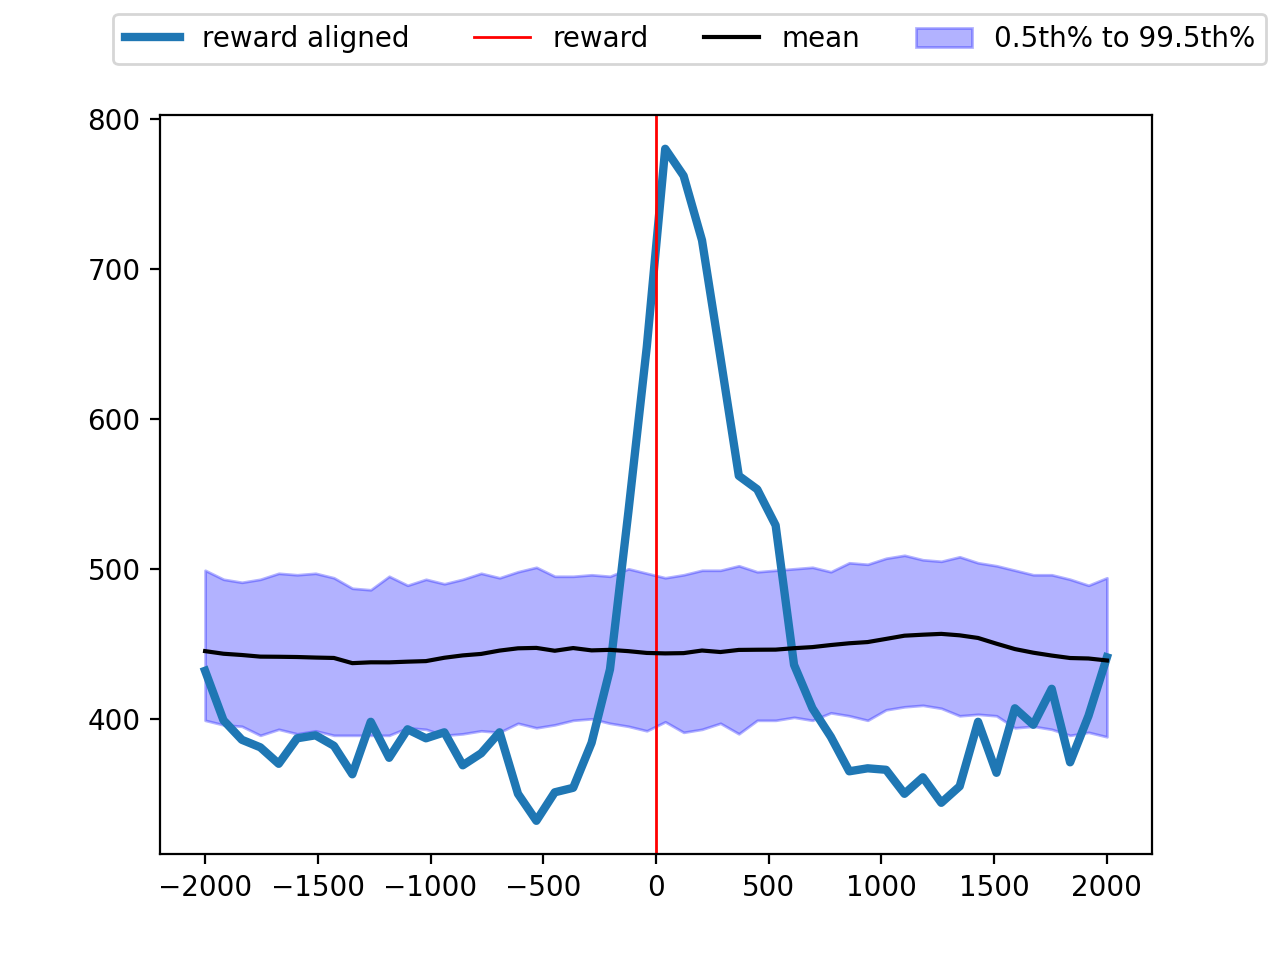

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [155]:
plt_compare_random_fixed(48,window,bins,reward_aligned_ar,mean_ar,percentil_ar)

<IPython.core.display.Javascript object>


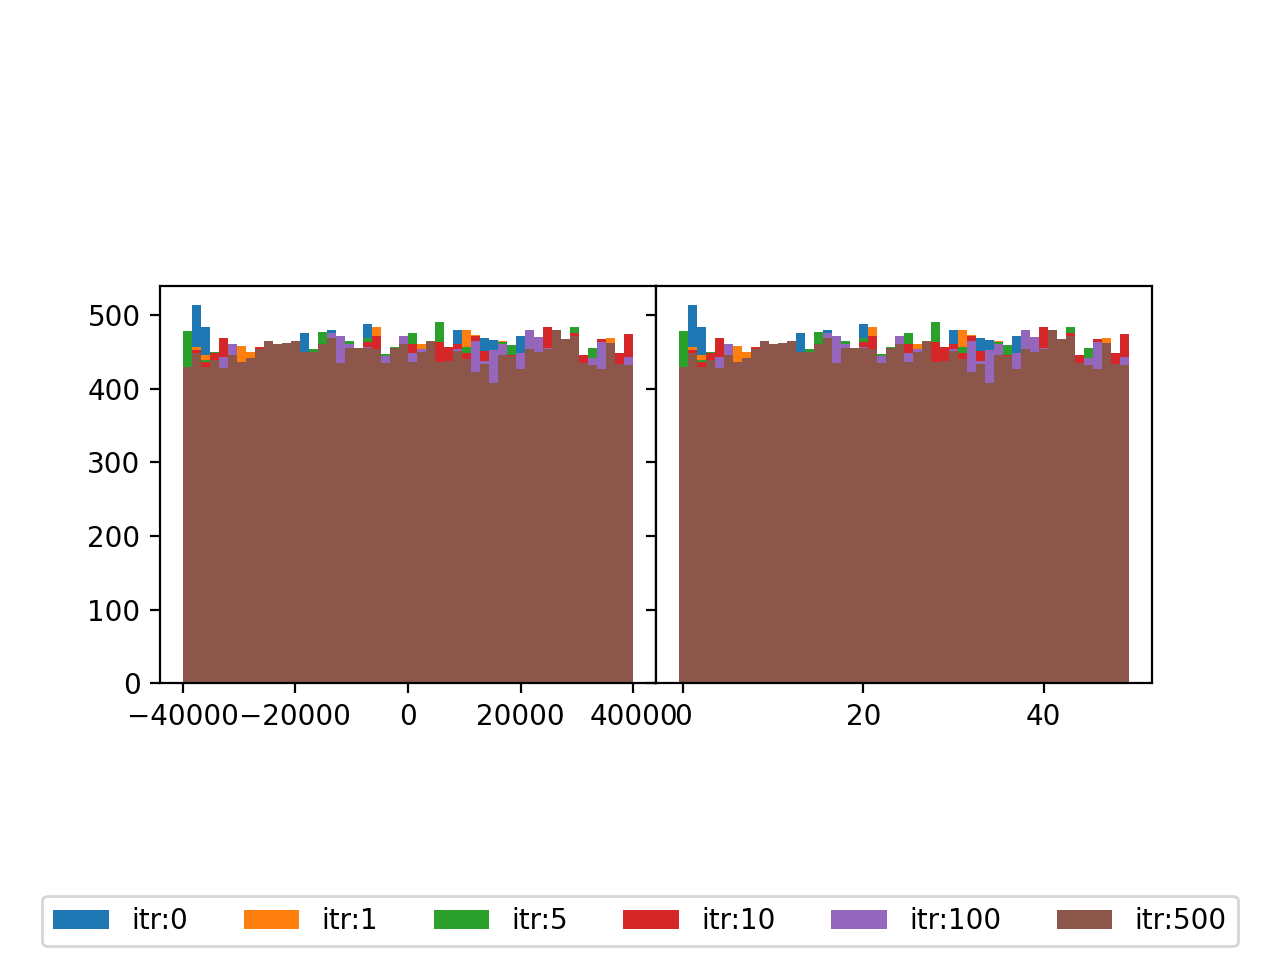

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [154]:
plt_test_plot_raw_spikes(spiketimes_data_ar, binned, 48, bins)

In [48]:
count_wrong_max=0
count_wrong_min=0
for trial in range(x):
    if random_ar[trial].max() > trial_ar[trial,1]:
        count_wrong_max+=1
    if random_ar[trial].min() < trial_ar[trial,0]:
        count_wrong_min+=1
print(count_wrong_min)
print(count_wrong_min)

0
0


<IPython.core.display.Javascript object>


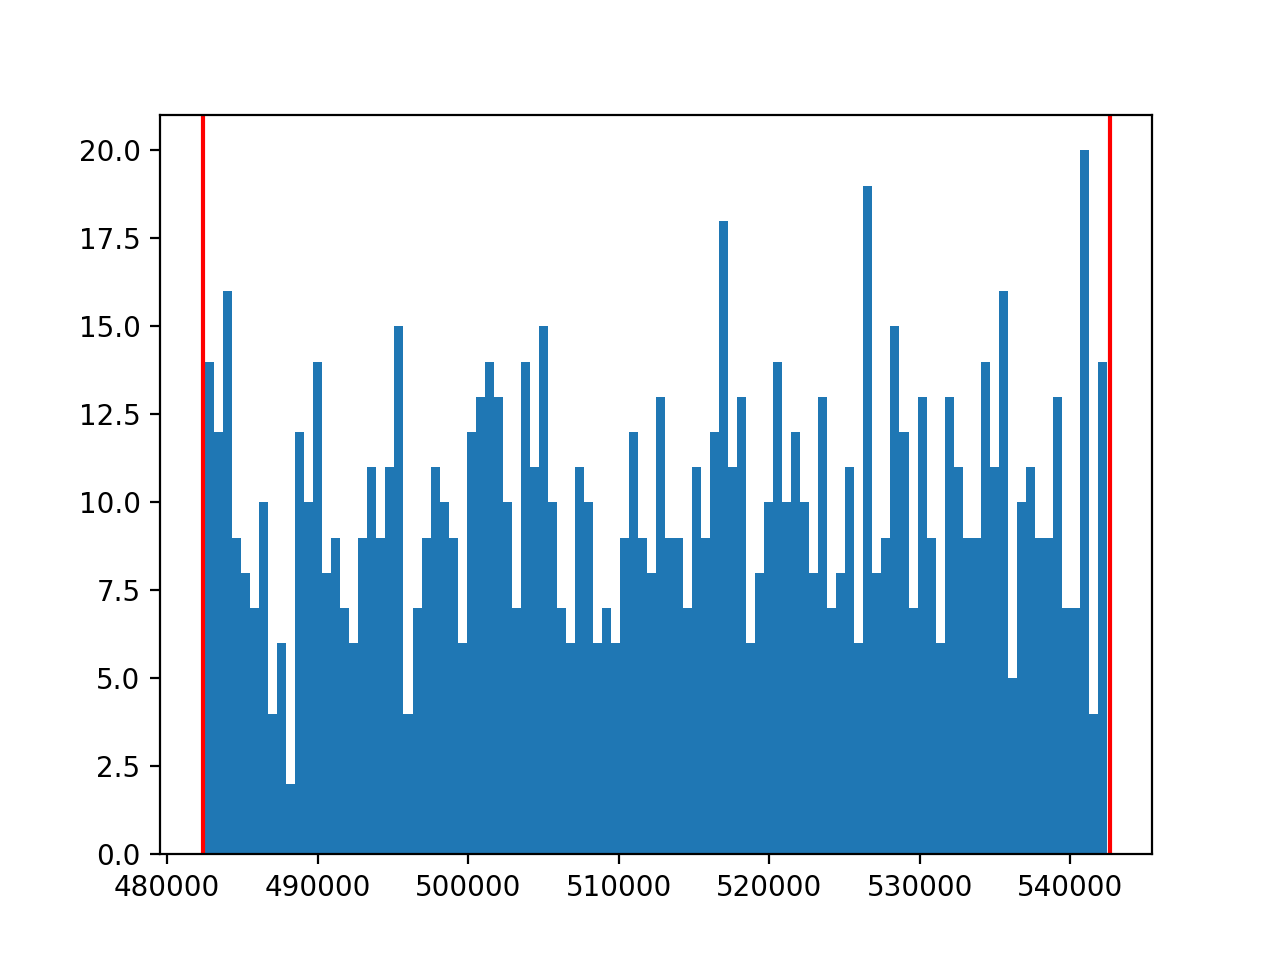

In [64]:
fig,ax = plt.subplots()
ax.hist(random_ar[0],bins=100)
ax.axvline(trial_ar[0,0],color='red')
ax.axvline(trial_ar[0,1],color='red')

<IPython.core.display.Javascript object>


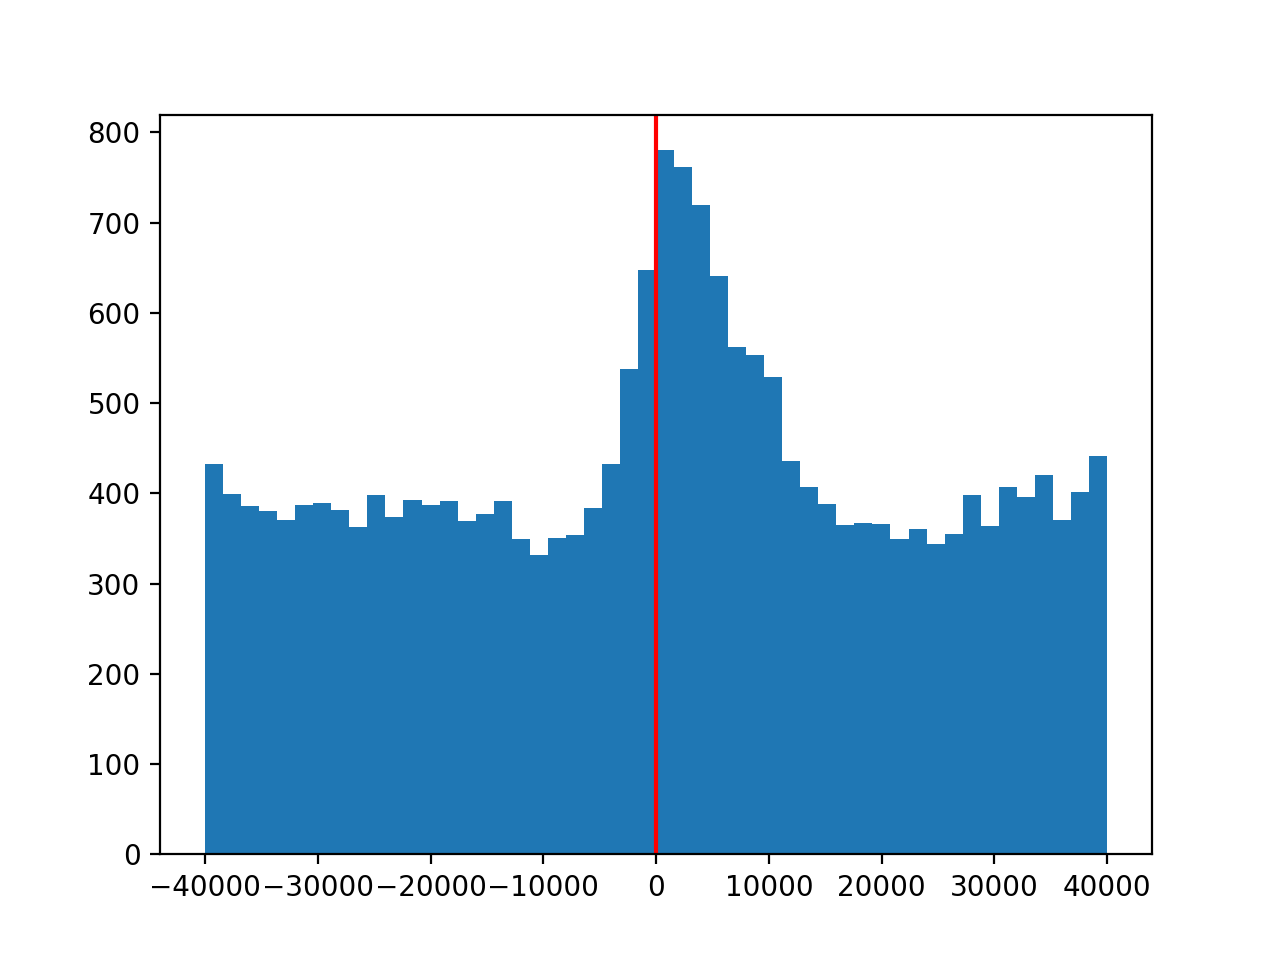

In [104]:
fig,ax = plt.subplots()
ax.hist(np.concatenate(reward_aligned_ar[48]).ravel(),bins=50)
ax.axvline(0,color='red')